In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from nltk.stem import *
from nltk.corpus import stopwords
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import time
import sklearn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, cohen_kappa_score,make_scorer
import pickle

In [4]:
df = pd.read_excel('iphproductdata2_8.xlsx')
df.head()

Country Code         IPH Category IPH Sub Category  \
0           AT  General Merchandise        Batteries   
1           AT  General Merchandise        Batteries   
2           AT  General Merchandise        Batteries   
3           AT  General Merchandise        Batteries   
4           AT  General Merchandise        Batteries   

                                        Product  \
0  LL Altartikel Varta longlife Mono D 1,5V 1St   
1          Varta Electronics CR2016 Blister 2St   
2                   Varta Knopfzelle CR2025 2St   
3                Varta longlife Mono D 1,5V 1St   
4          Varta Longlife Power 9V Blister 10St   

                     Product Description Product Code  Gross Sales USD  
0     OL: Varta longlife Mono D 1.5V 1st       100832        1708.0190  
1   Varta Electronics CR2016 Blister 2pc       116270         391.2206  
2          OL: Varta Erlectronics CR2025       110202        2789.4703  
3     OL: Varta longlife Mono D 1.5V 1st       100832        1819.7663  
4  Varta Longlife Power 9V Blister 10pcs       100836         111.1617

In [5]:
df.isna().sum()

Country Code              0
IPH Category              0
IPH Sub Category          0
Product                   0
Product Description       0
Product Code              0
Gross Sales USD        1304
dtype: int64

In [6]:
df = df.drop(index=df[df.duplicated(['Product Description'])].index) 

In [7]:
df['Final_Category'] = df['IPH Category'].str.cat(df[['IPH Sub Category']].values,sep=' - ')

In [8]:
df['Final_Category'].head()

0    General Merchandise - Batteries
1    General Merchandise - Batteries
2    General Merchandise - Batteries
4    General Merchandise - Batteries
6    General Merchandise - Batteries
Name: Final_Category, dtype: object

In [9]:
df['Final_Category'].nunique()

43

In [10]:
final_categories_counts = df['Final_Category'].value_counts().sort_values(ascending=True)

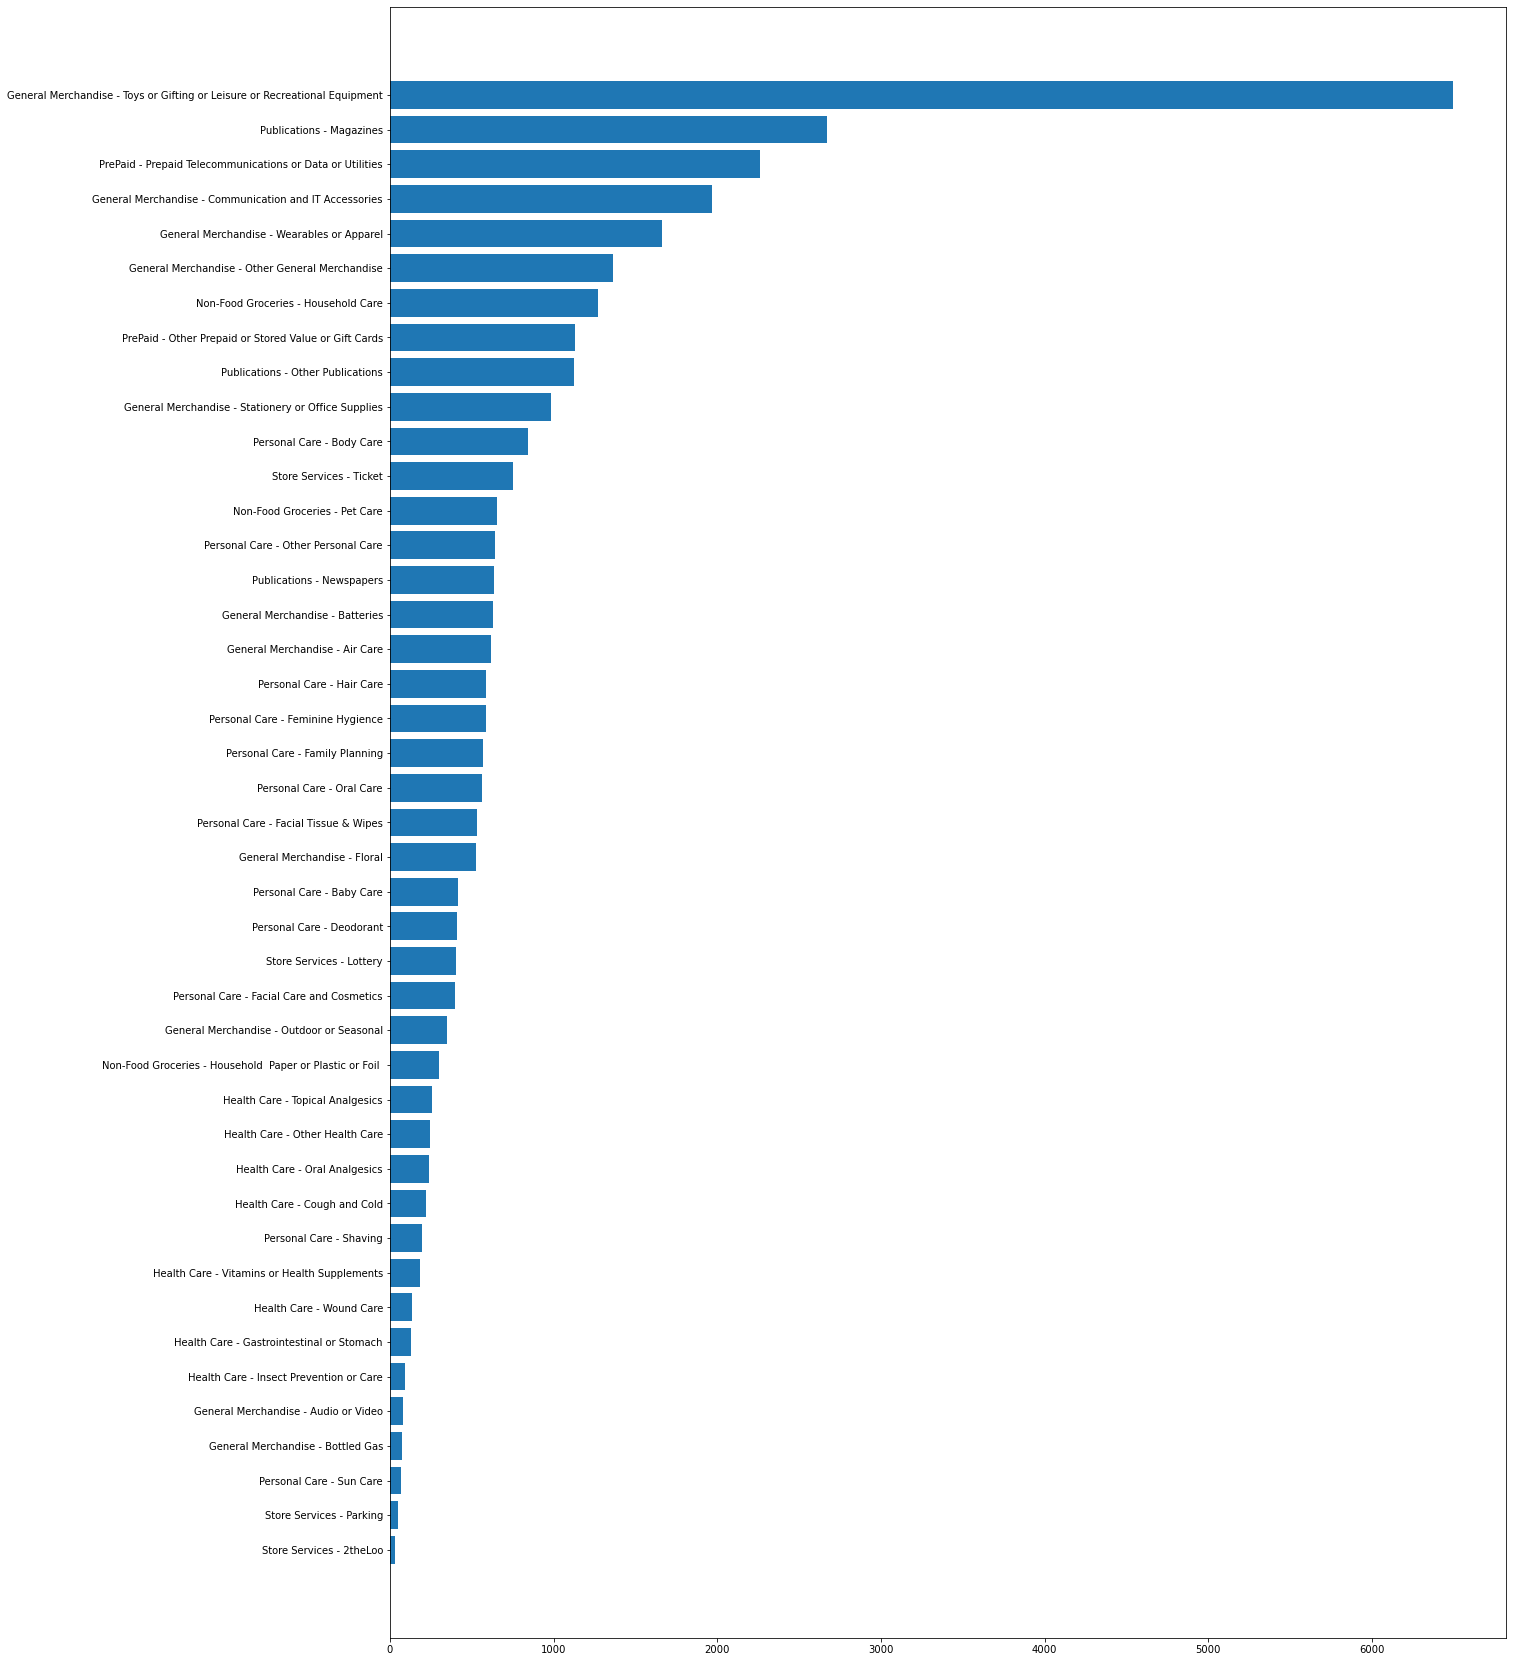

In [11]:
plt.figure(figsize=(20,30))
plt.barh(final_categories_counts.index, final_categories_counts)
plt.xlabel=None

In [12]:
final_categories_counts.head(30)

Store Services - 2theLoo                                      32
Store Services - Parking                                      47
Personal Care - Sun Care                                      70
General Merchandise - Bottled Gas                             72
General Merchandise - Audio or Video                          77
Health Care - Insect Prevention or Care                       94
Health Care - Gastrointestinal or Stomach                    130
Health Care - Wound Care                                     137
Health Care - Vitamins or Health Supplements                 186
Personal Care - Shaving                                      195
Health Care - Cough and Cold                                 218
Health Care - Oral Analgesics                                236
Health Care - Other Health Care                              243
Health Care - Topical Analgesics                             258
Non-Food Groceries - Household  Paper or Plastic or Foil     302
General Merchandise - Out

In [13]:
small_count_categories = final_categories_counts[final_categories_counts<=5].index

In [14]:
len(small_count_categories)

0

In [15]:
df['Final_Category'].replace(to_replace=small_count_categories, value='Other', inplace=True)

In [16]:
df['codes'] = df['Final_Category'].astype('category').cat.codes
df['codes'].nunique()

43

In [17]:
code_dictionary = dict(set(list(zip(df['codes'], df['Final_Category']))))

In [18]:
X = df['Product Description']
y = df['codes']

In [19]:
tokenizer = WhitespaceTokenizer()

In [20]:
#from wordcloud import WordCloud
#word_cloud = WordCloud(width = 1000,
                       #height = 800,
                       #colormap = 'Blues', 
                       #margin = 0,
                       #max_words = 183,  
                       #max_font_size = 120, min_font_size = 15,  
                       #background_color = "white").generate(" ".join(X_train))

#plt.figure(figsize = (10, 15))
#plt.imshow(word_cloud, interpolation = "gaussian")
#plt.axis("off")
#plt.show()

In [21]:
def plot_most_common_features(text_col, target_col, n_features=50):
    from matplotlib import interactive

    df = pd.DataFrame({"text": text_col, "CLASS": target_col})
    grouped = df.groupby(["CLASS"]).apply(lambda x: x["text"].sum())
    grouped_df = pd.DataFrame({"CLASS": grouped.index, "text": grouped.values})

    from nltk.tokenize import WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    for ii, text in enumerate(grouped_df.text):
        pd.DataFrame(tokenizer.tokenize(text)).apply(pd.value_counts).head(n_features).plot(kind="bar", cmap=plt.cm.seismic, figsize=(20,5))
        plt.title(grouped_df.CLASS[ii], fontsize=20)
        plt.xticks(fontsize=15)
        plt.legend([])
        interactive(True)
        plt.show()

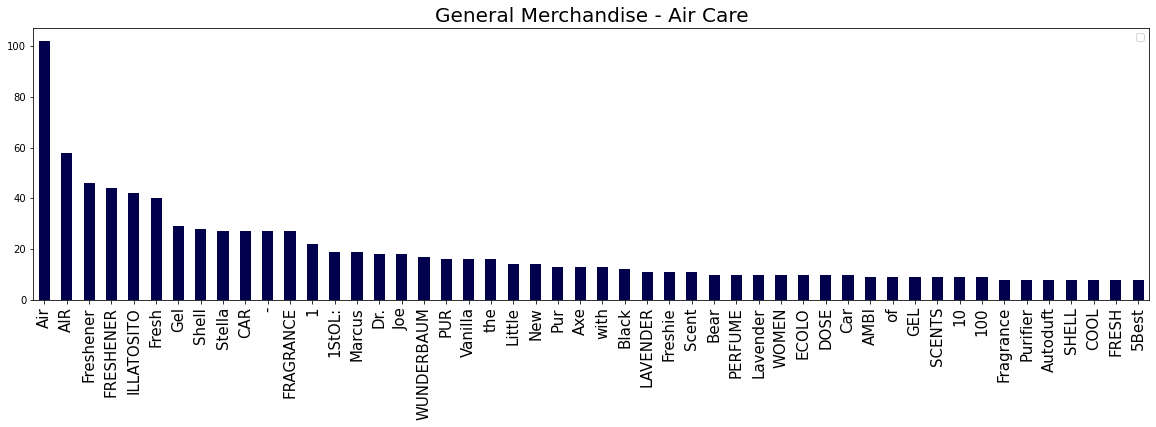

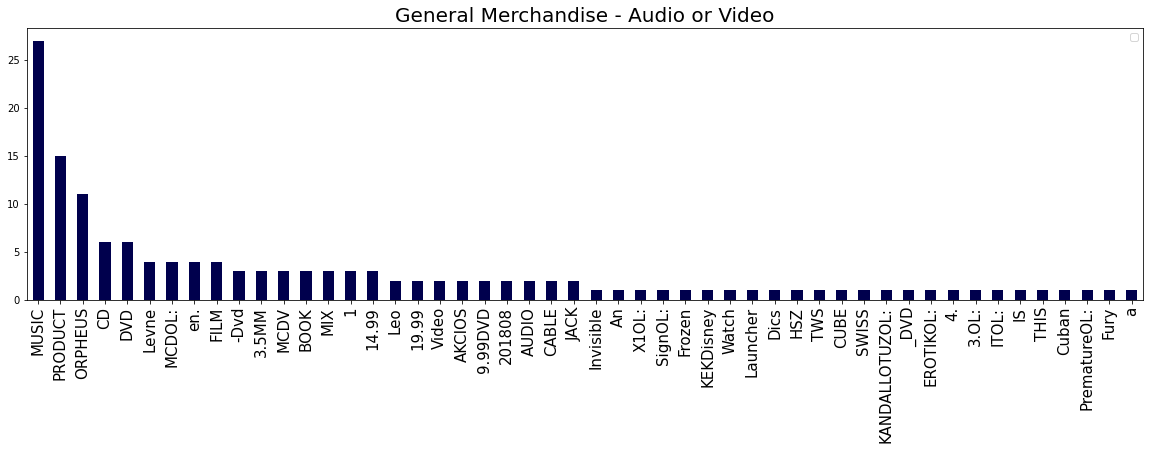

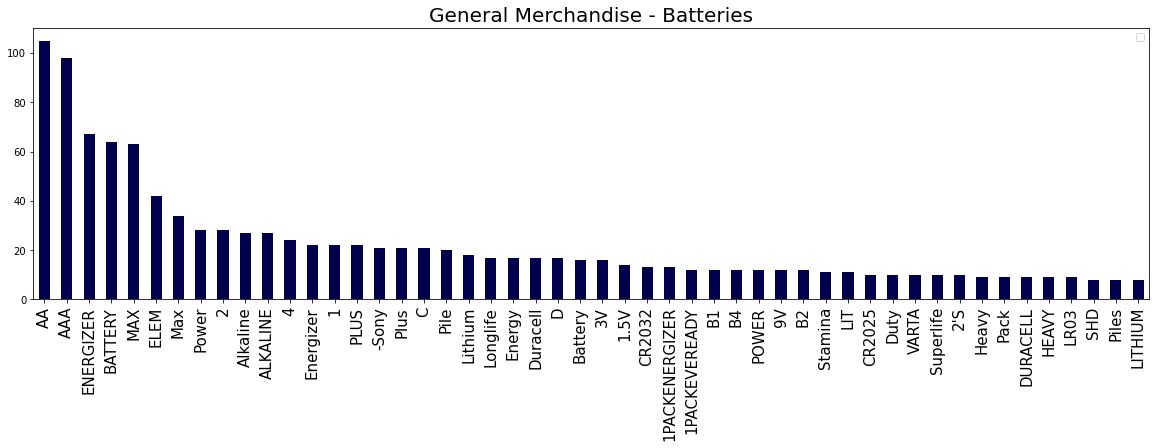

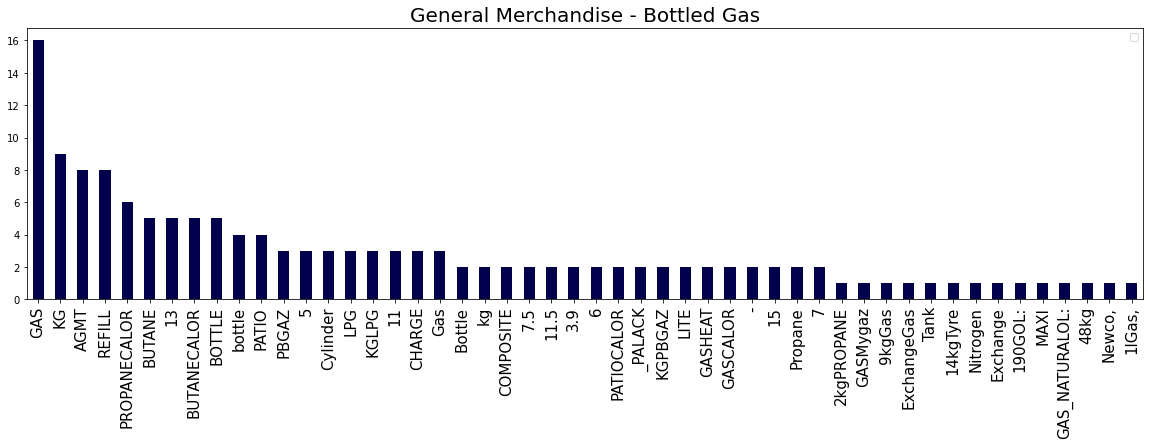

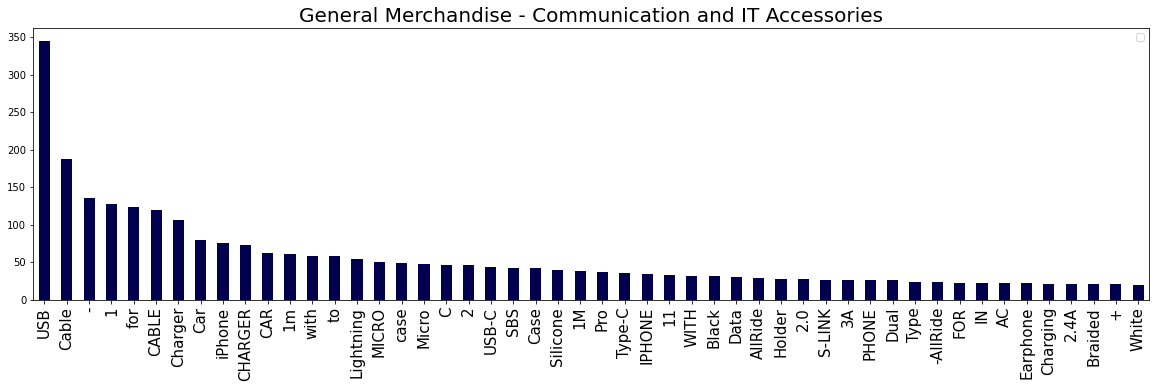

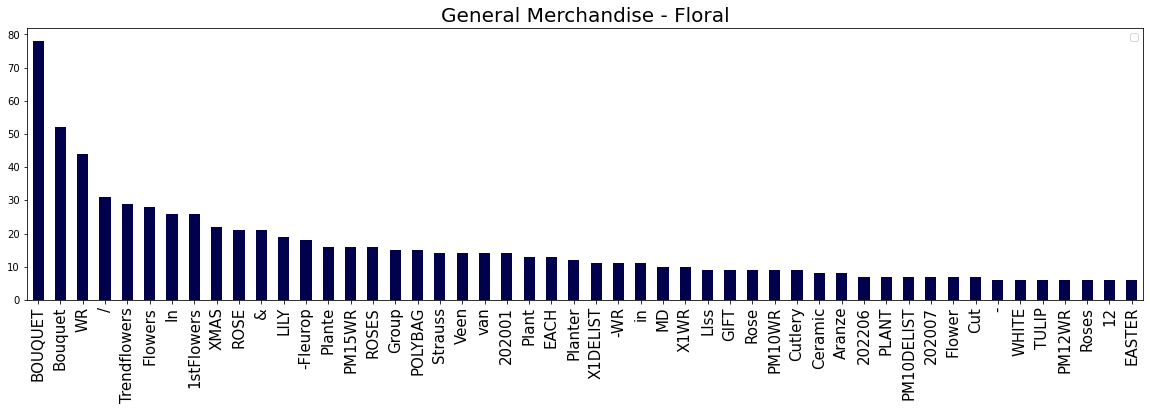

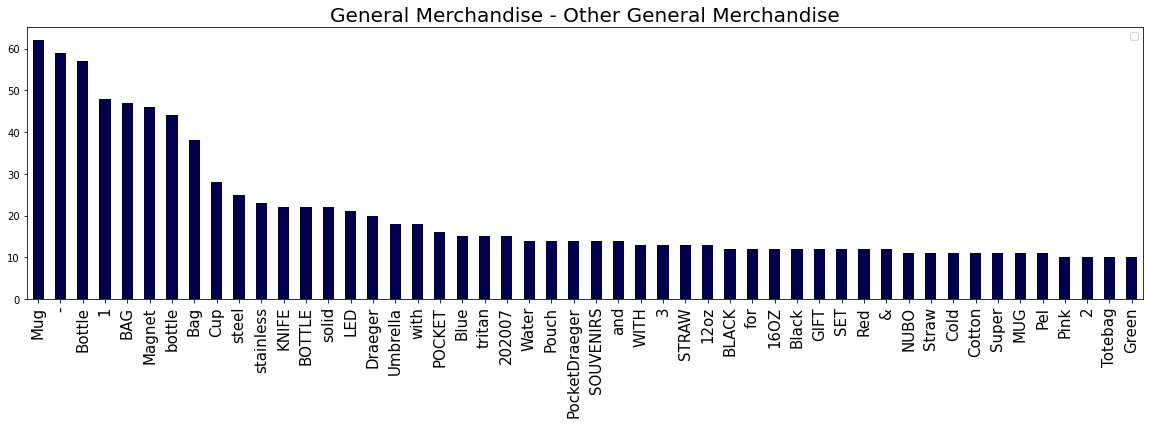

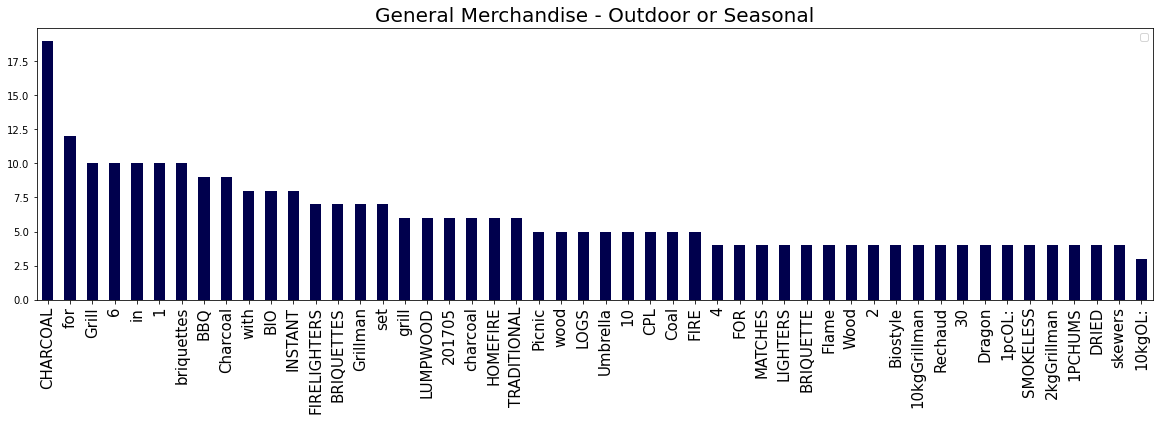

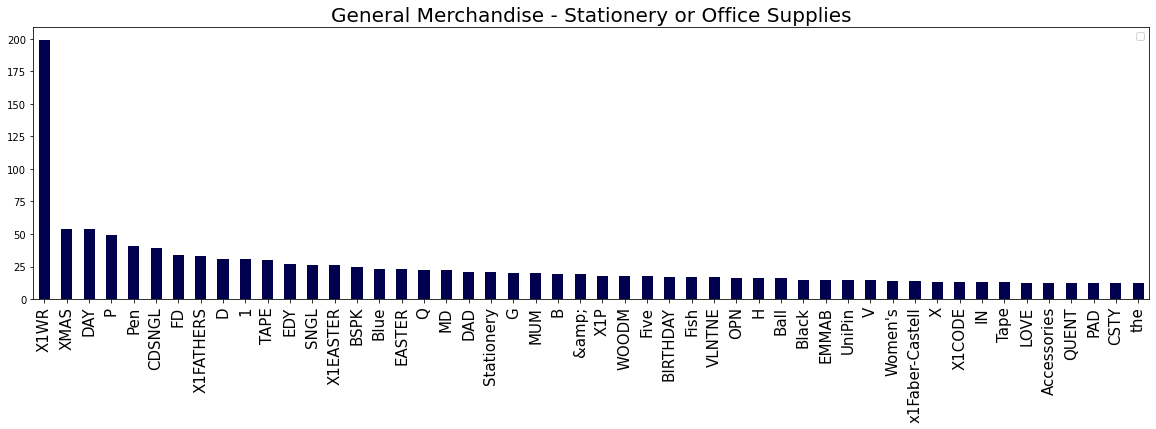

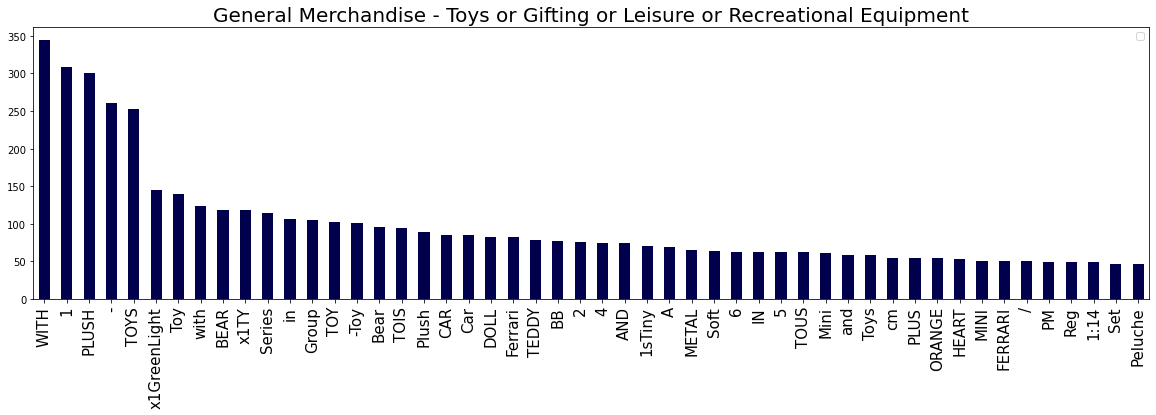

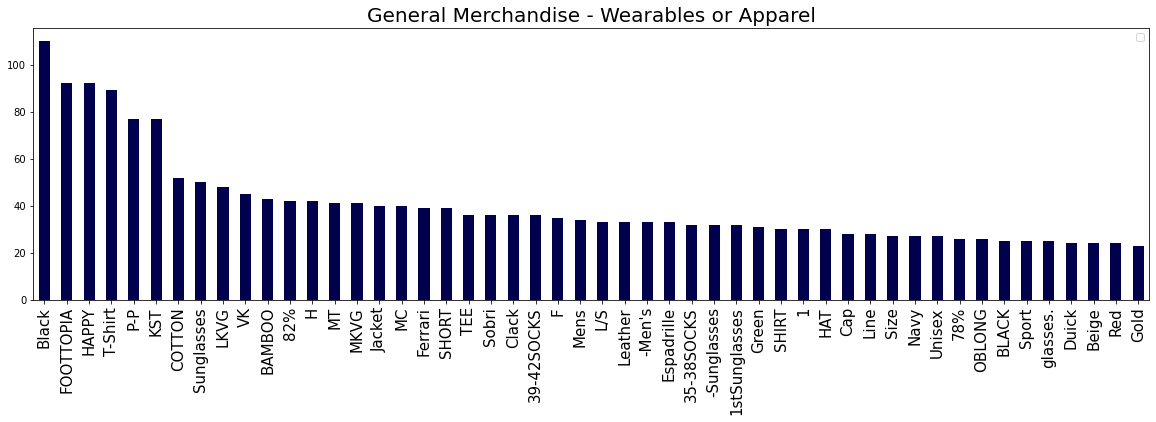

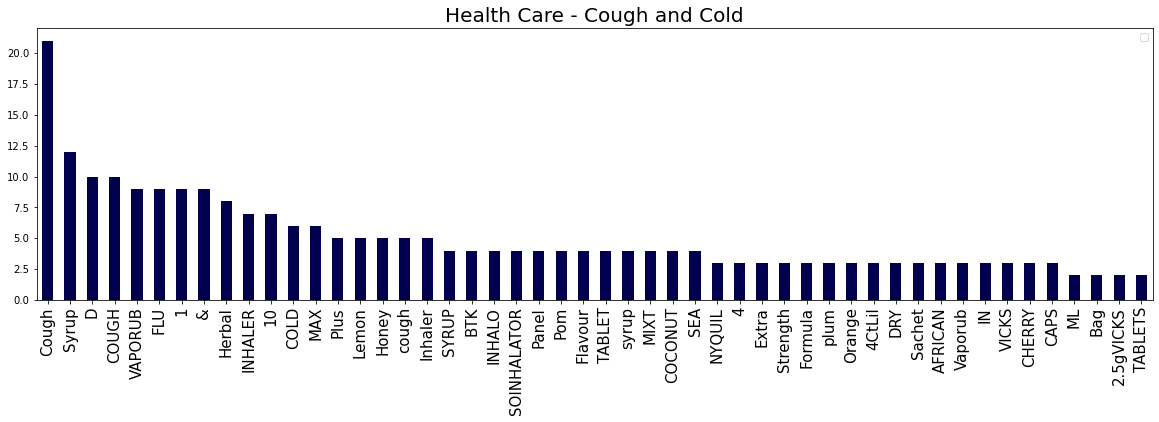

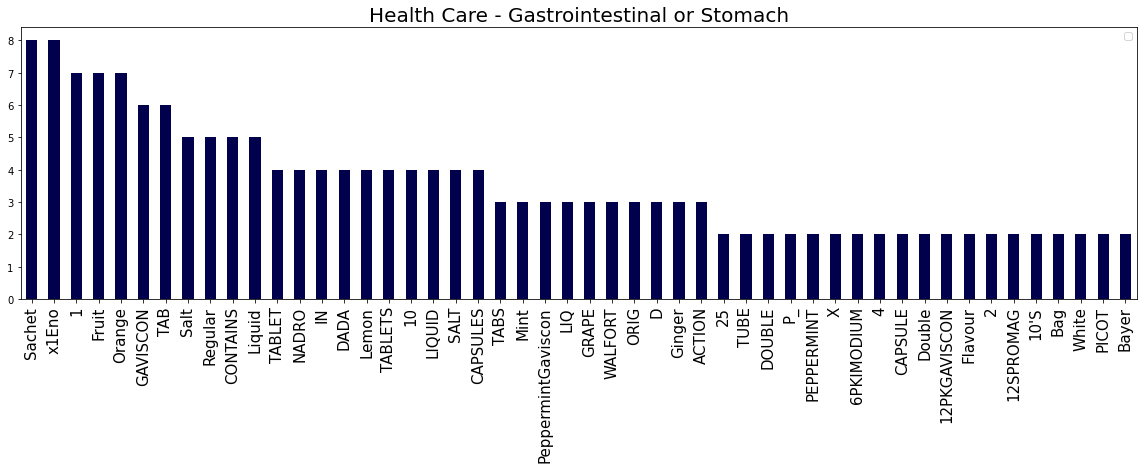

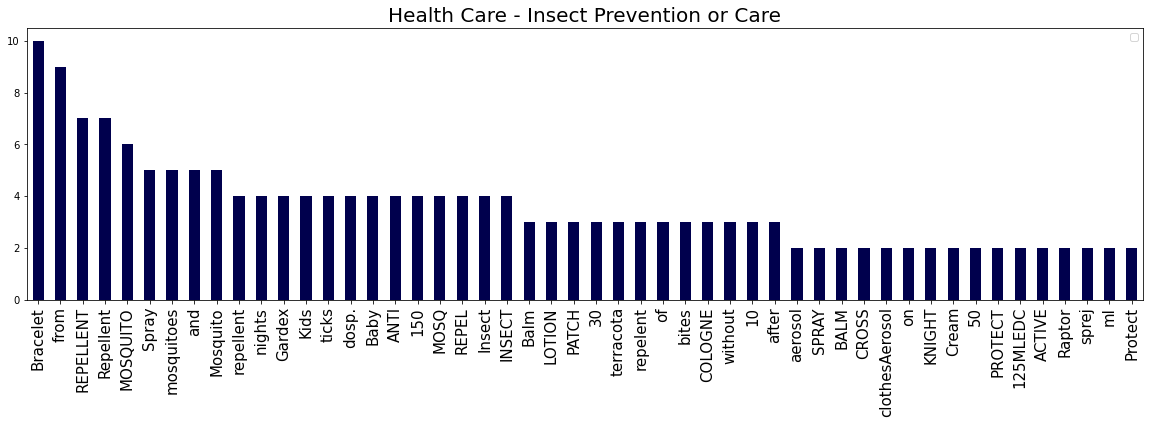

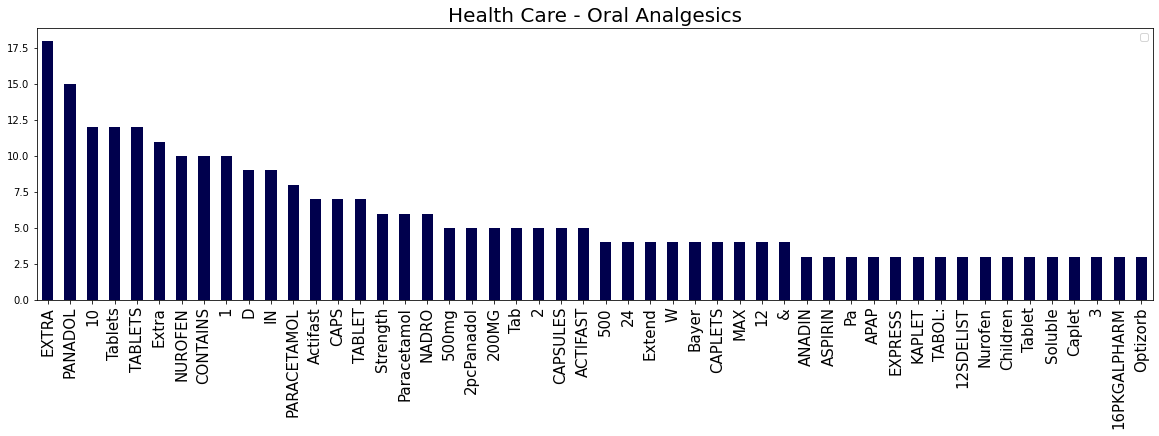

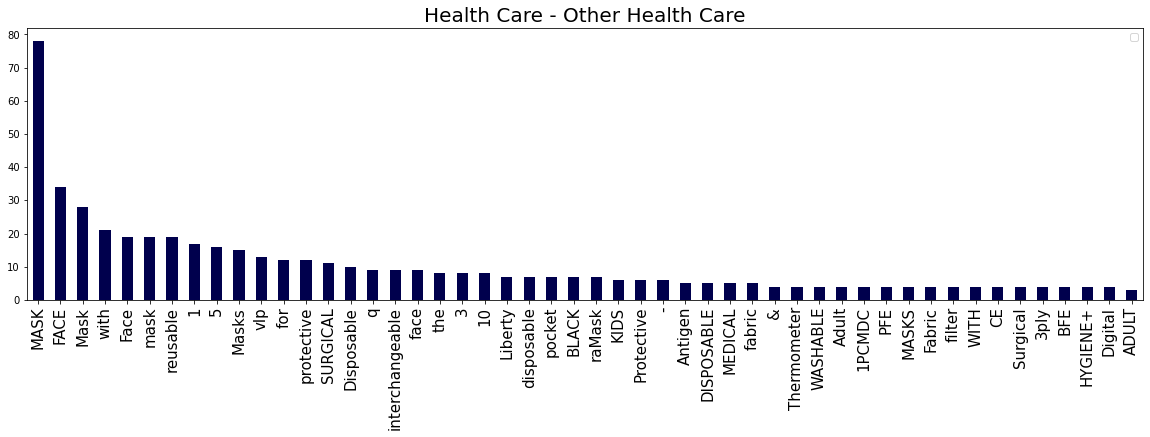

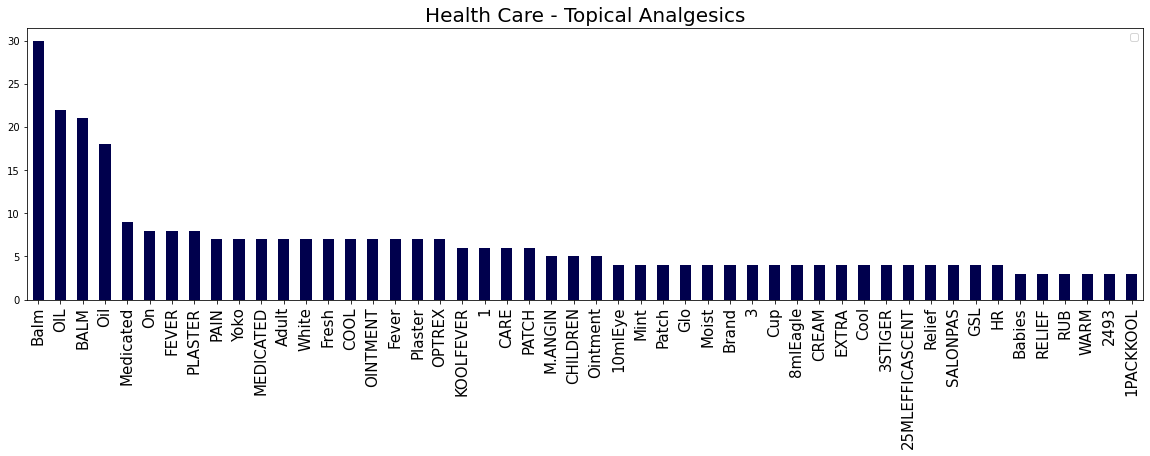

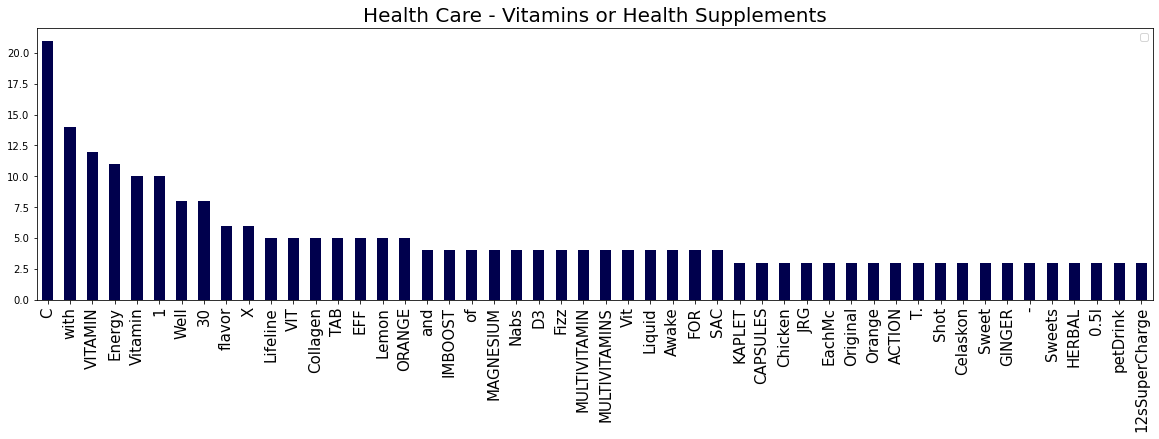

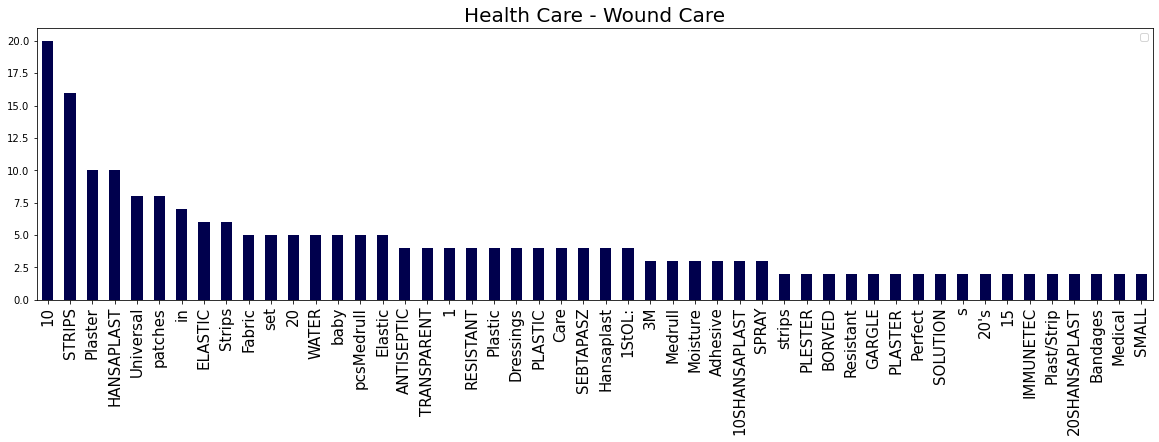

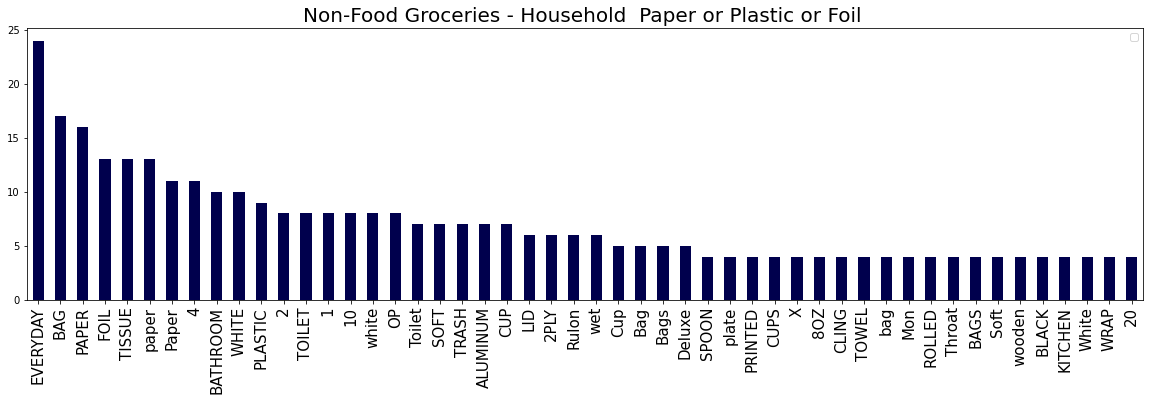

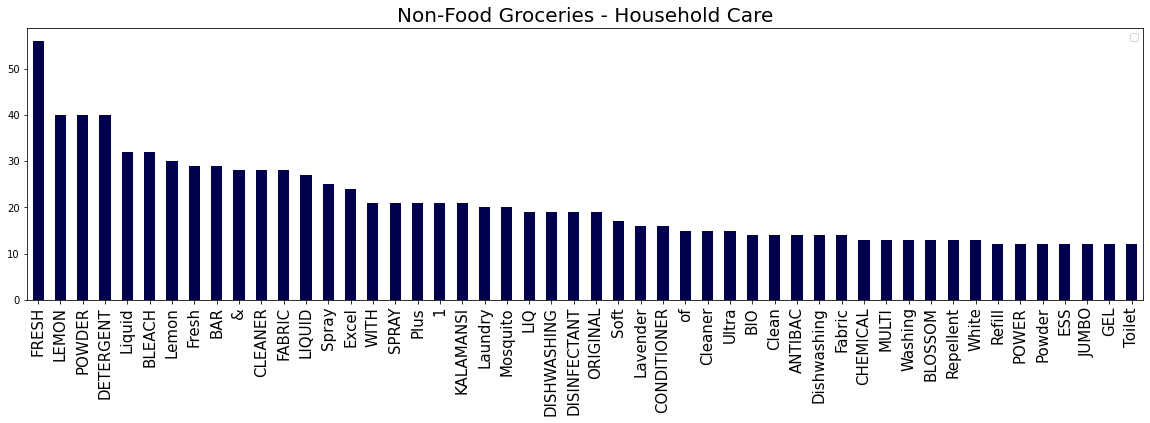

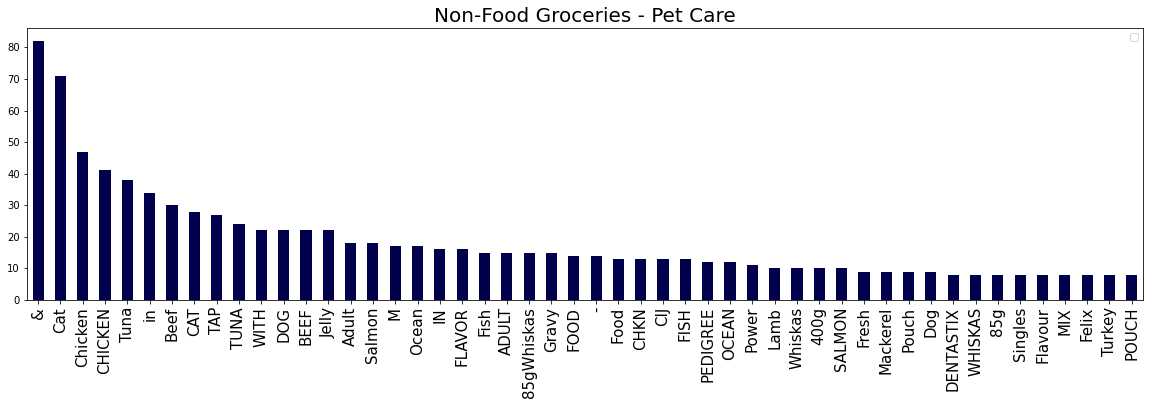

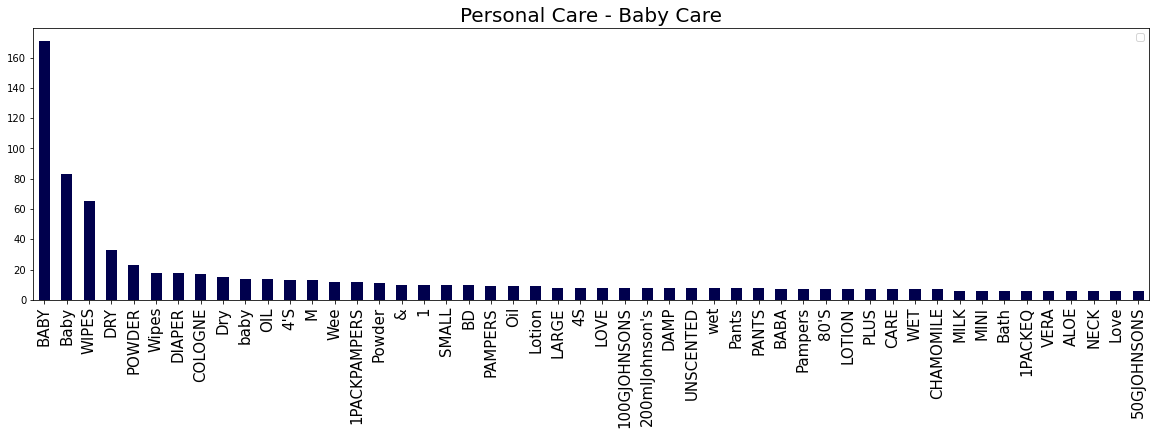

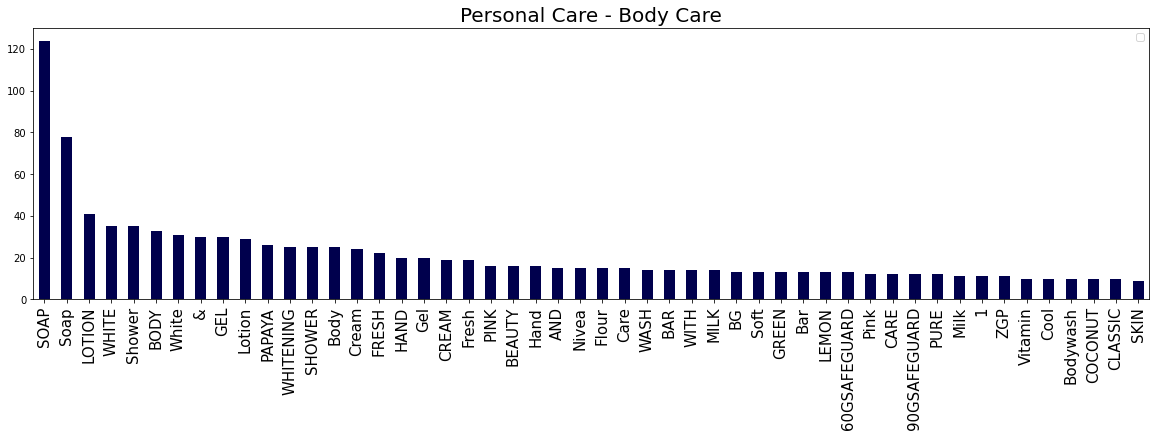

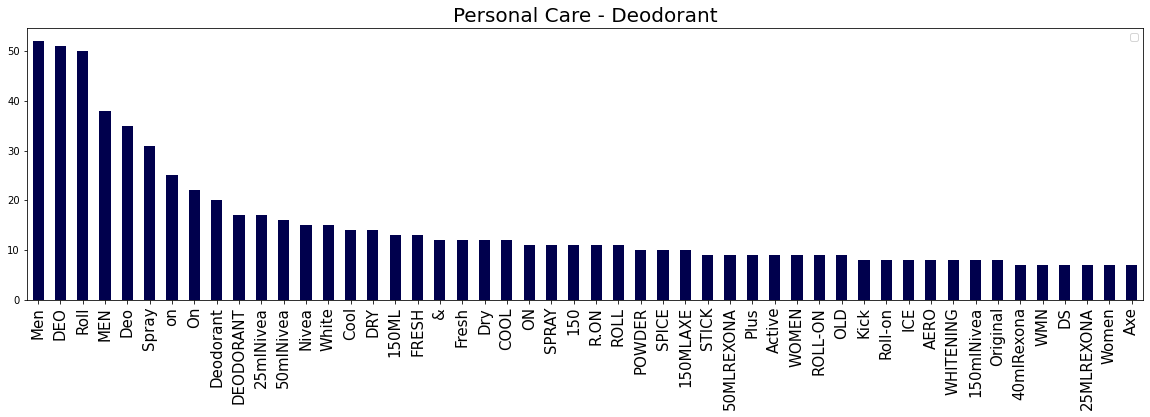

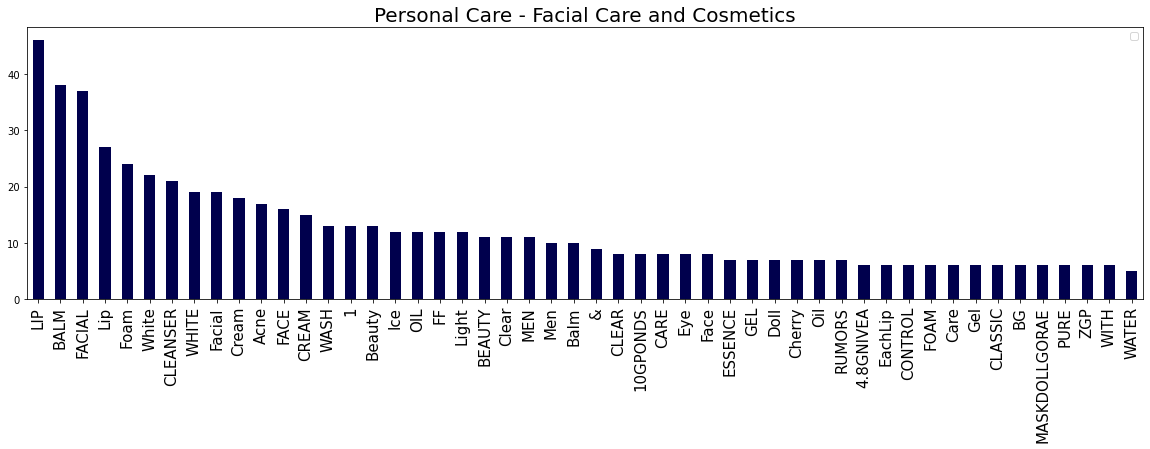

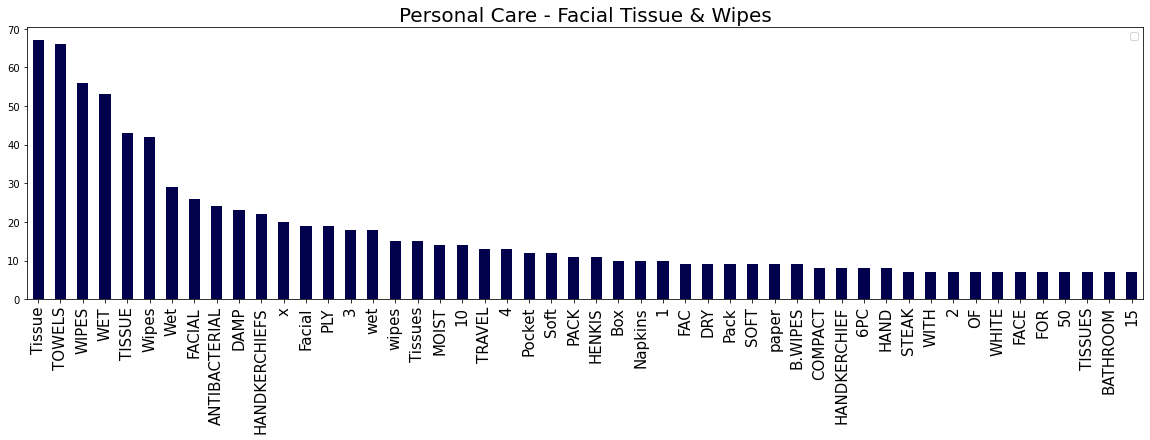

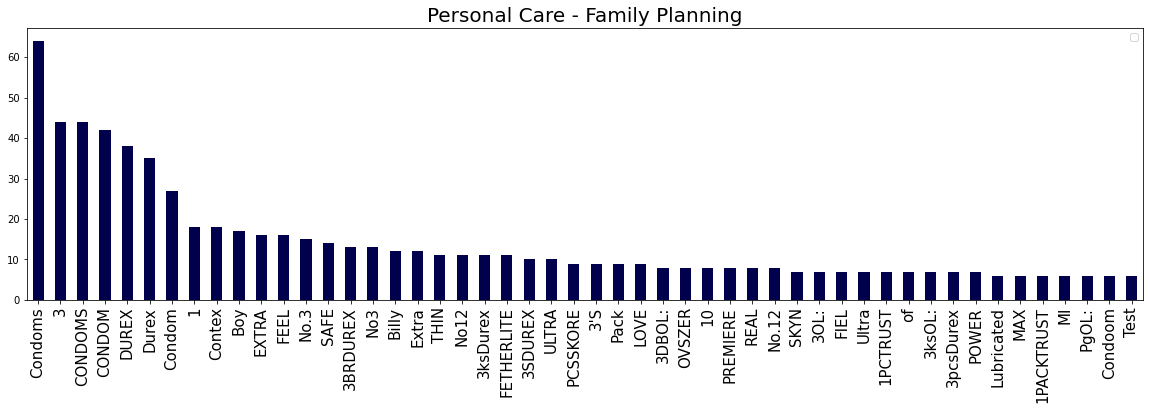

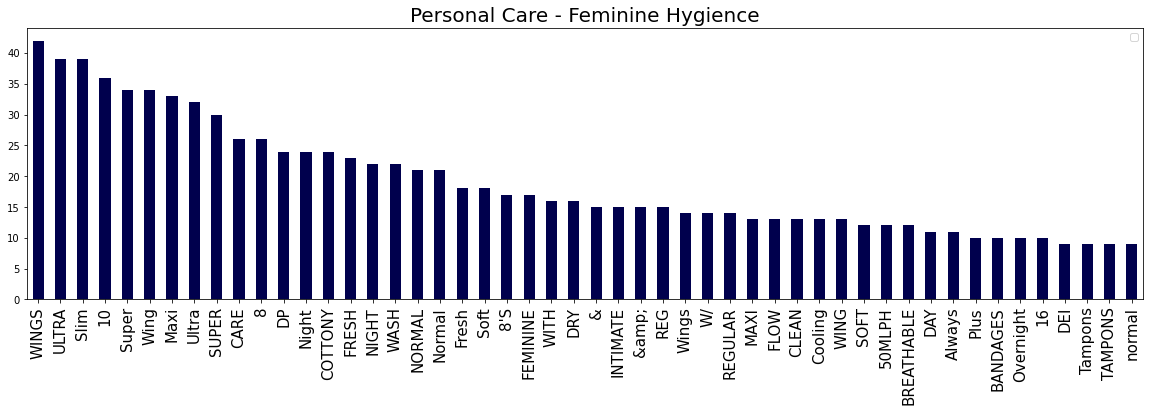

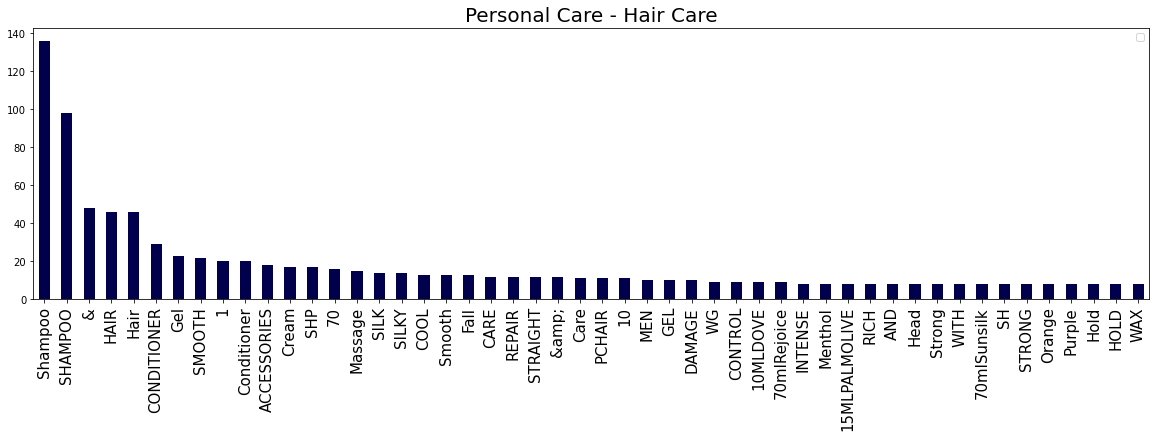

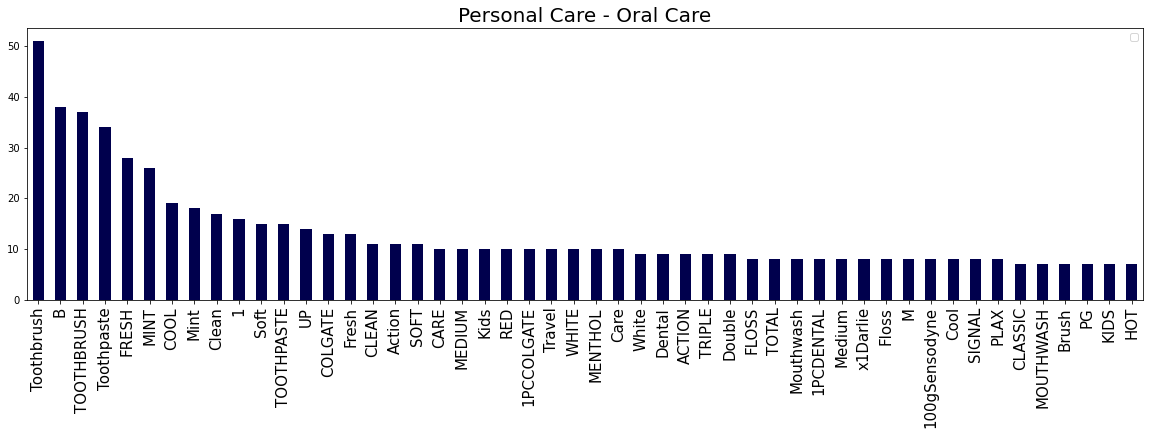

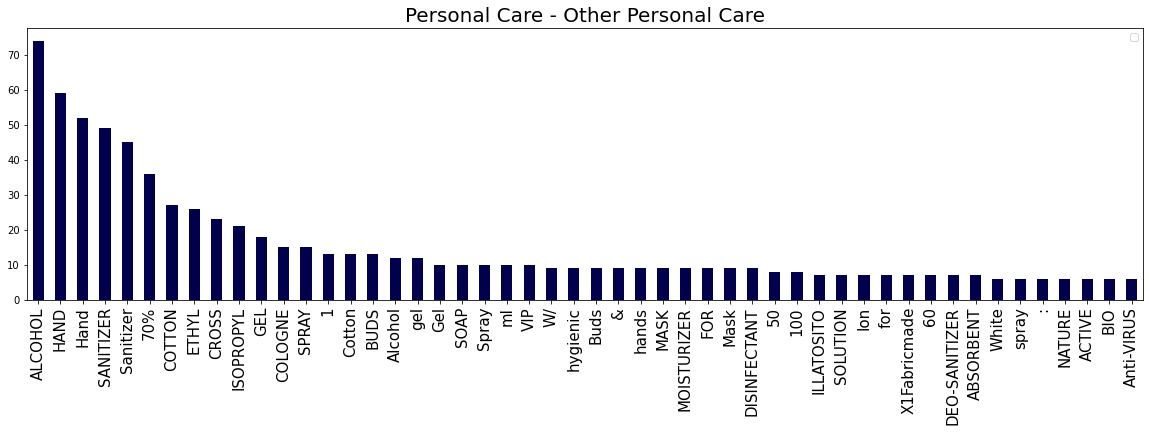

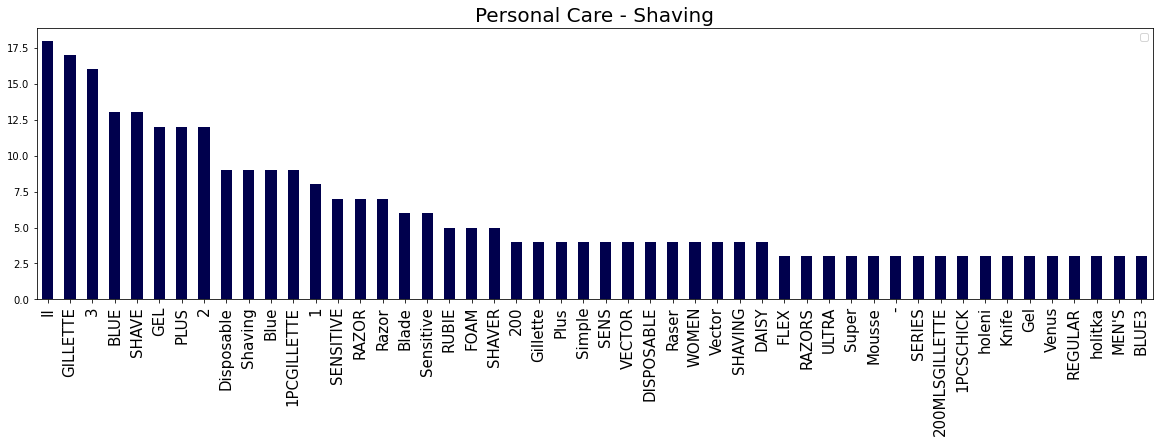

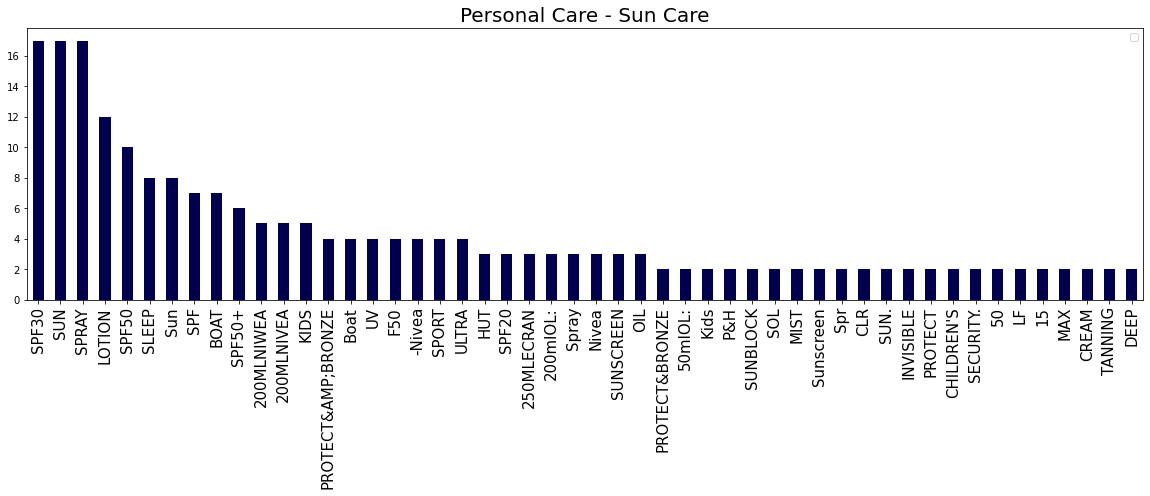

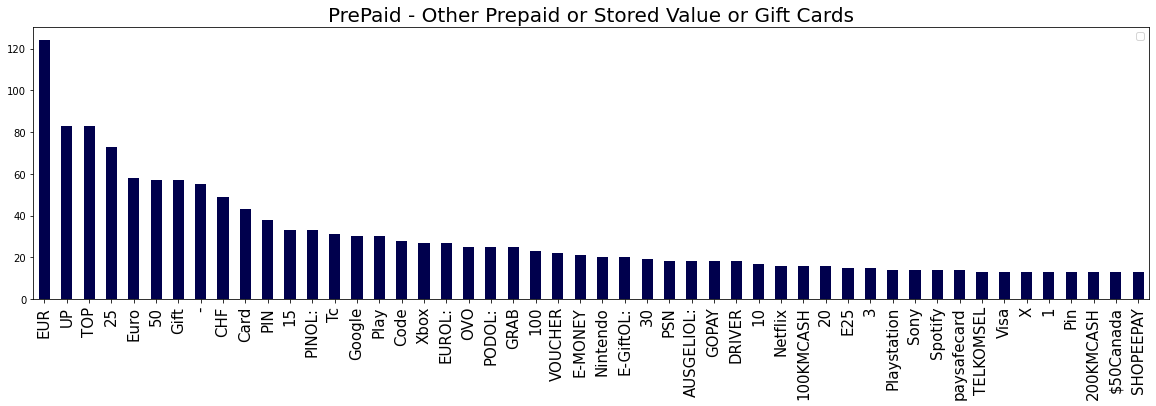

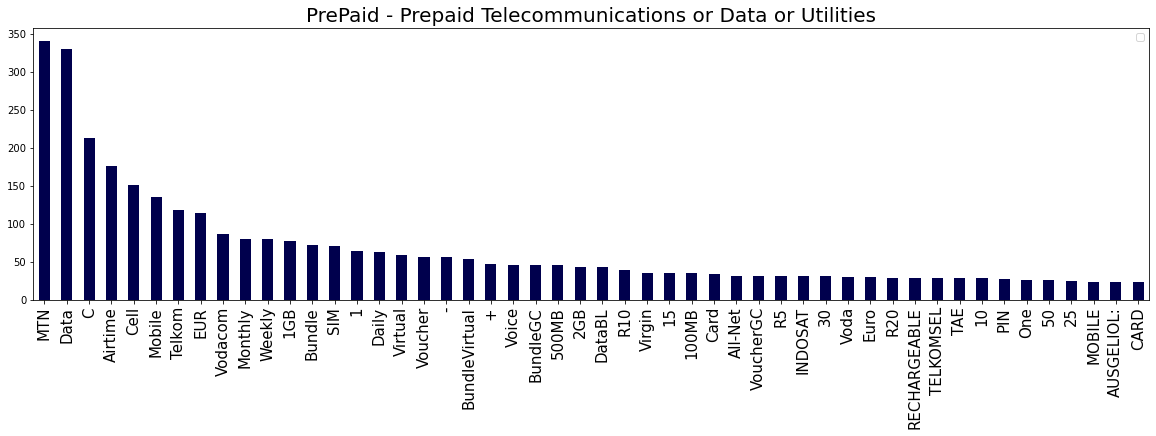

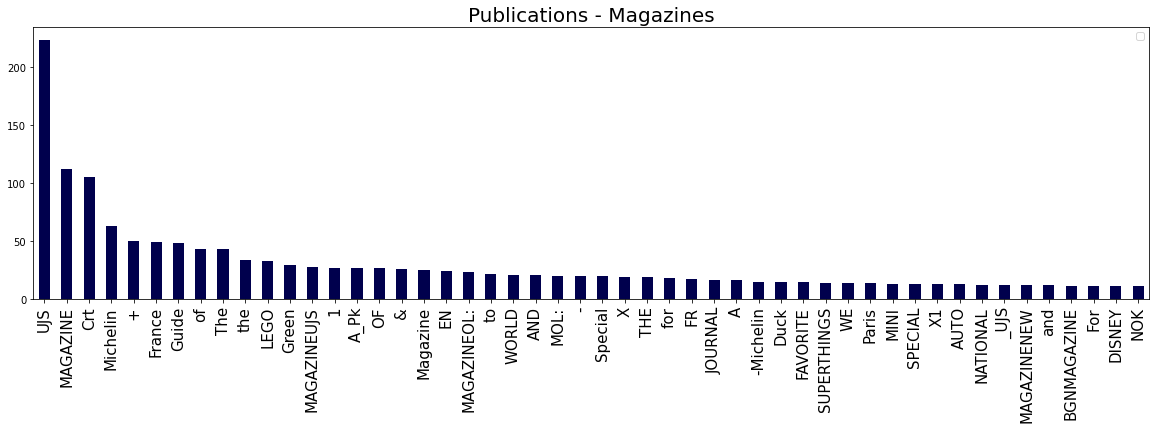

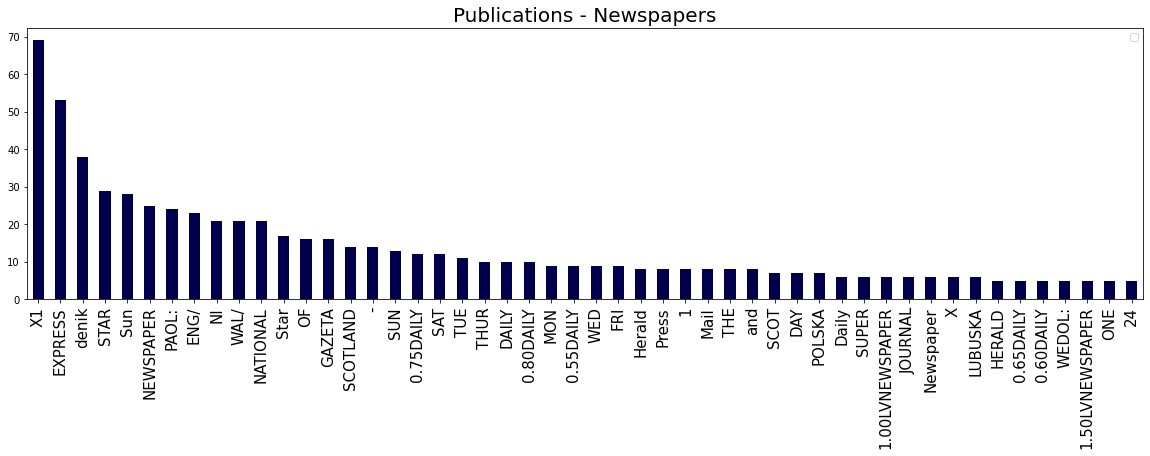

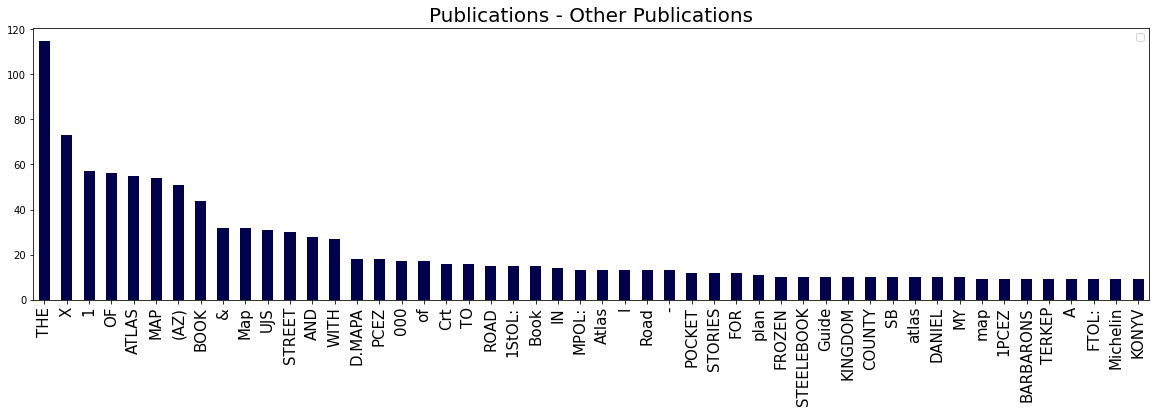

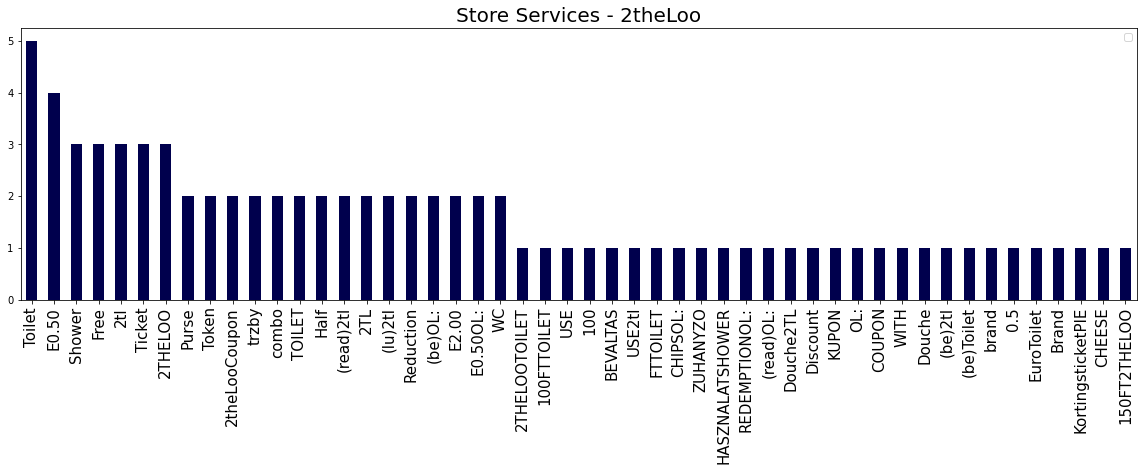

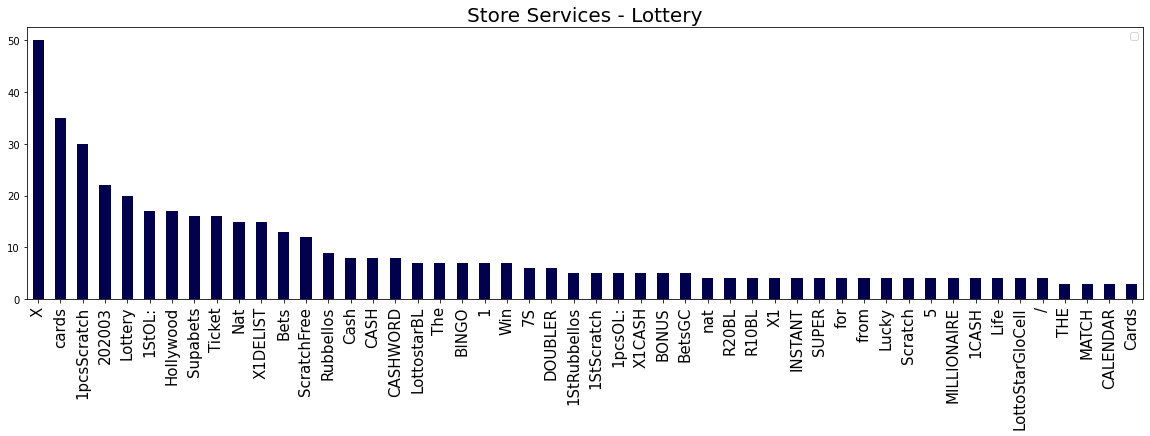

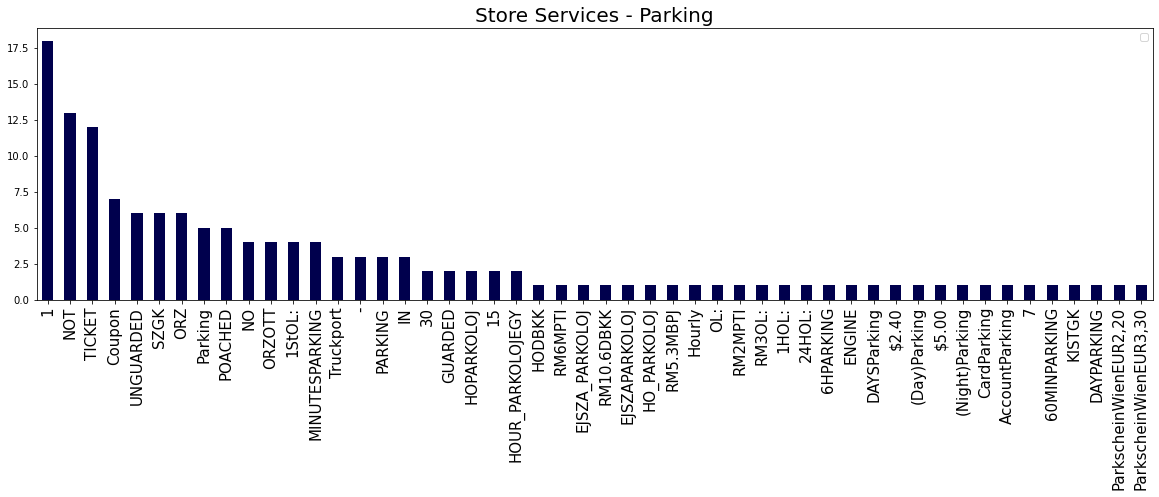

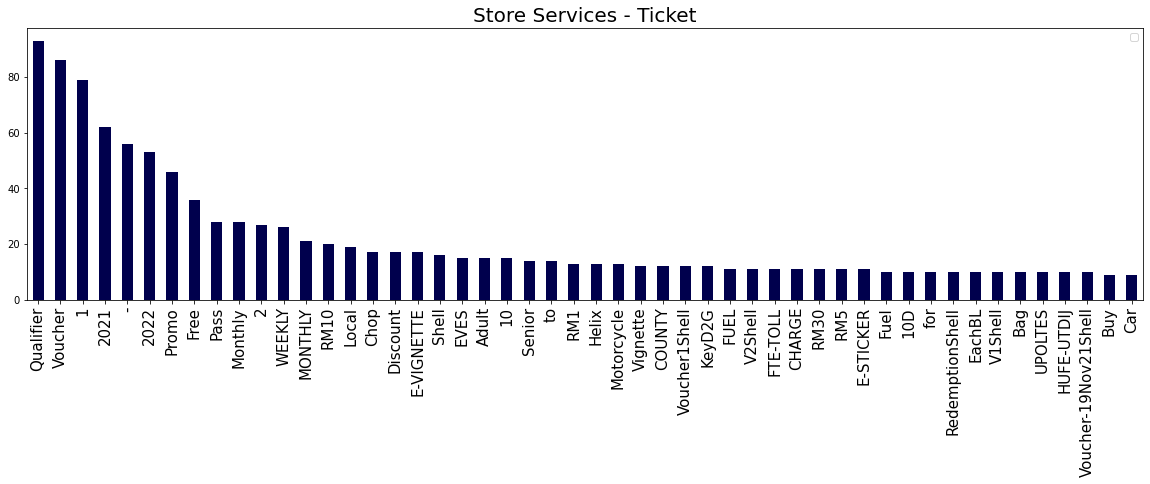

In [22]:
plot_most_common_features(X,df['Final_Category'])

In [23]:
nltk.download('stopwords')

from nltk.stem import SnowballStemmer


def stemming(raw_text):
    
    stemmer = SnowballStemmer('english')
    stemmed = [stemmer.stem(word) for word in raw_text]
    
    return("".join(stemmed))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\S.Subramanian2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
nltk.download('stopwords')

from nltk.stem import SnowballStemmer


def process_text(raw_text):

    letters_only = re.sub("[^a-zA-Z]", " ",raw_text)
    no_one_letter = re.sub(r"\b[a-zA-Z]\b","",letters_only)
    words = no_one_letter.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]

    final_words = [word for word in not_stop_words]
    
    return( " ".join( final_words ))  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\S.Subramanian2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
X_cleaner = X.apply(lambda x: process_text(x))

In [26]:
X_cleaner_2 = X_cleaner.apply(lambda x: stemming(x))

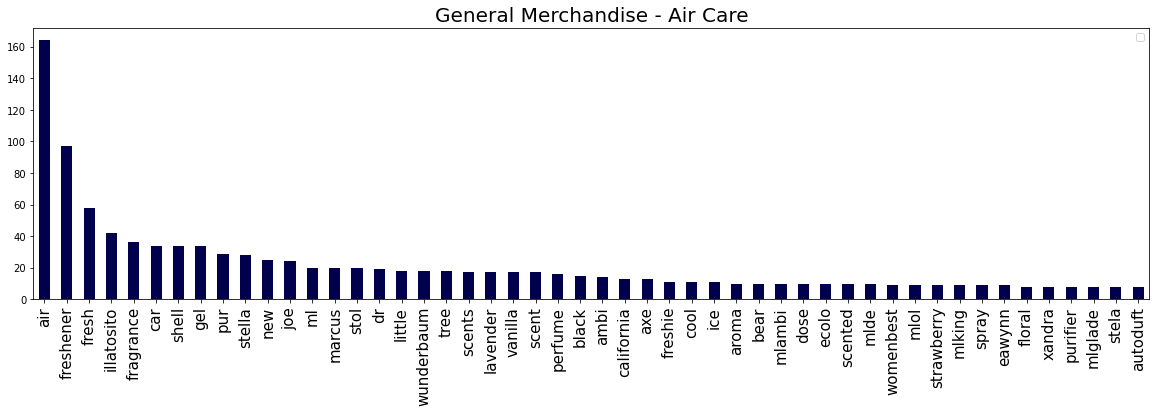

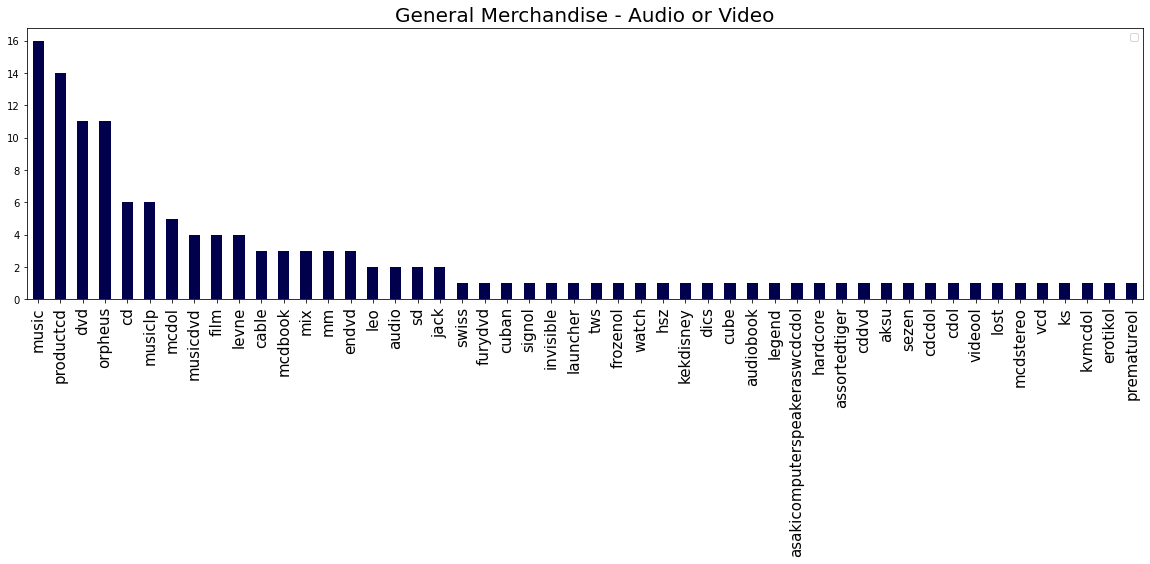

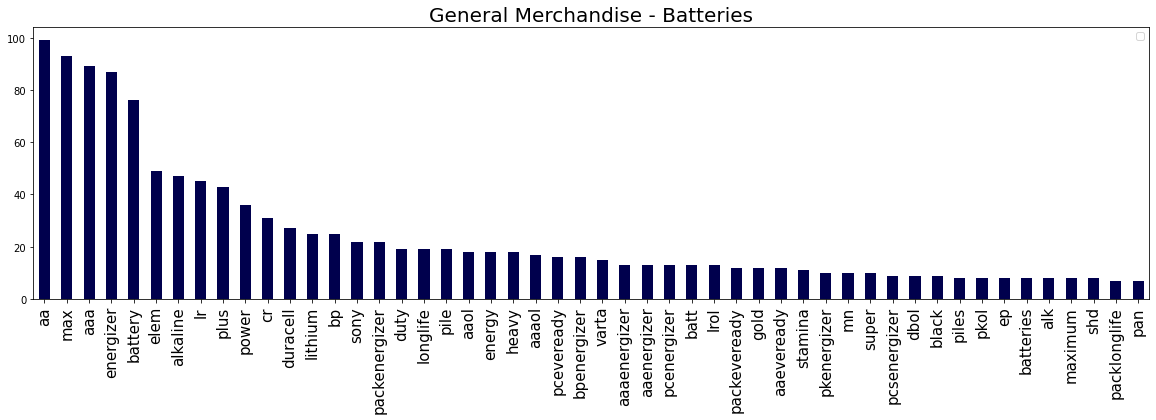

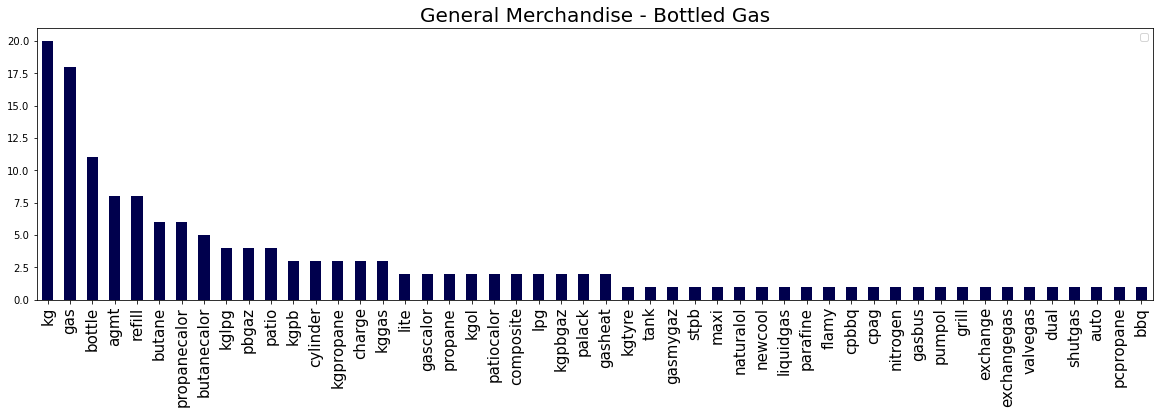

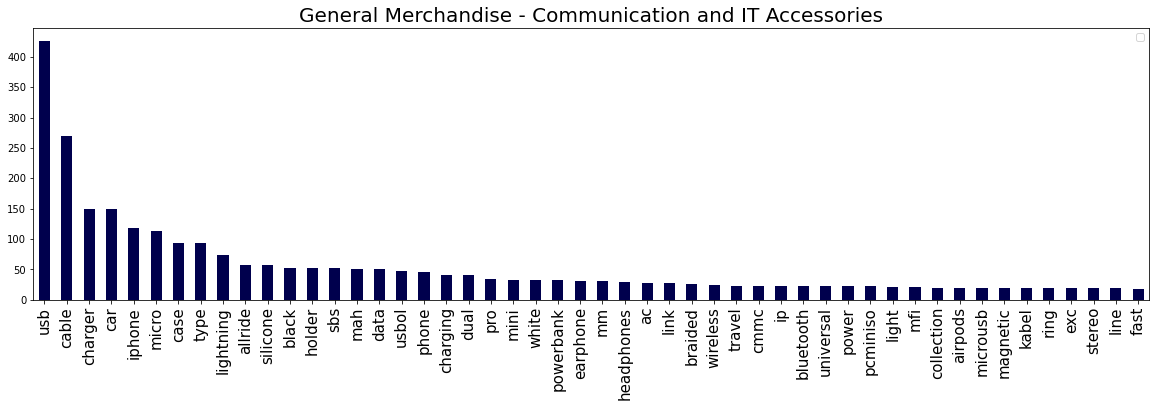

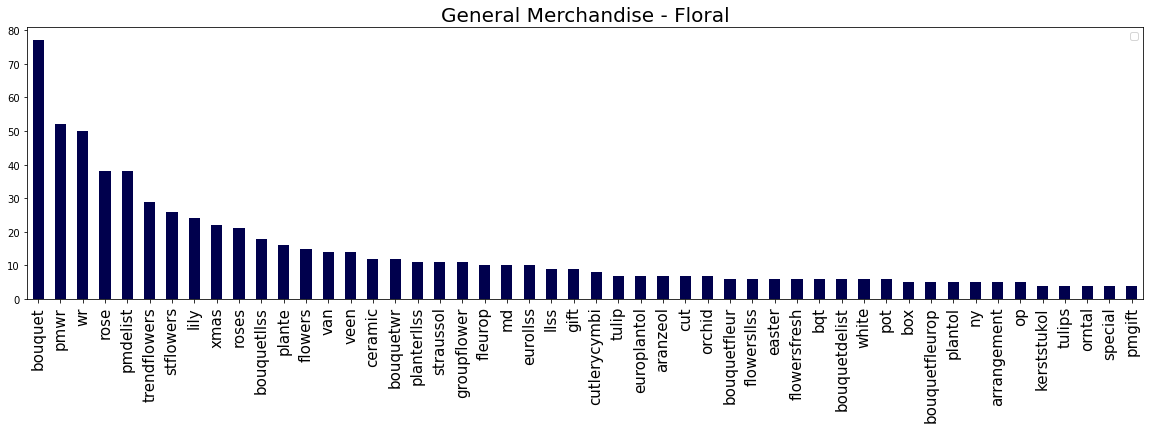

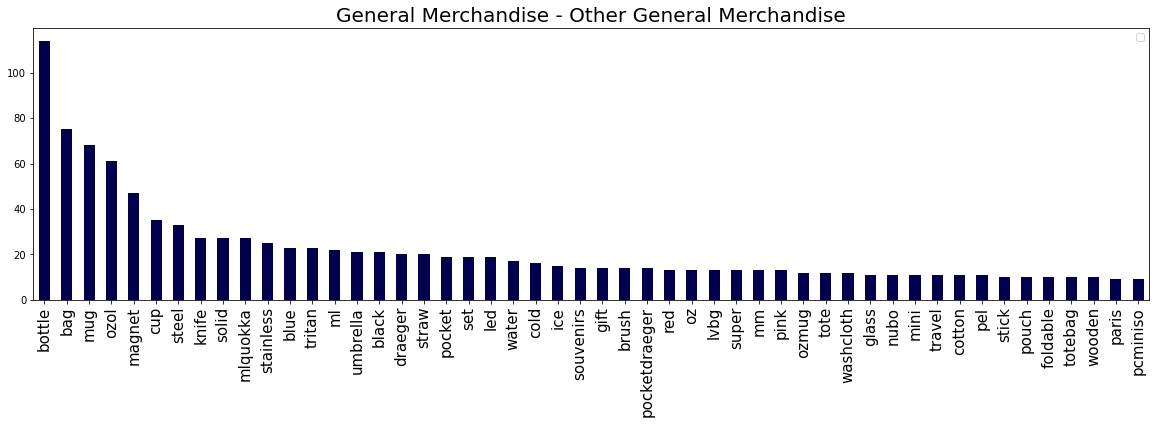

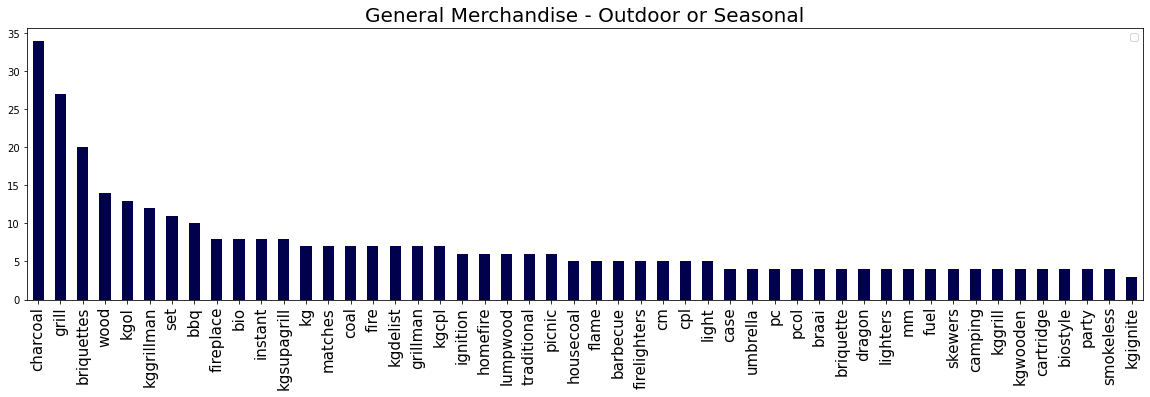

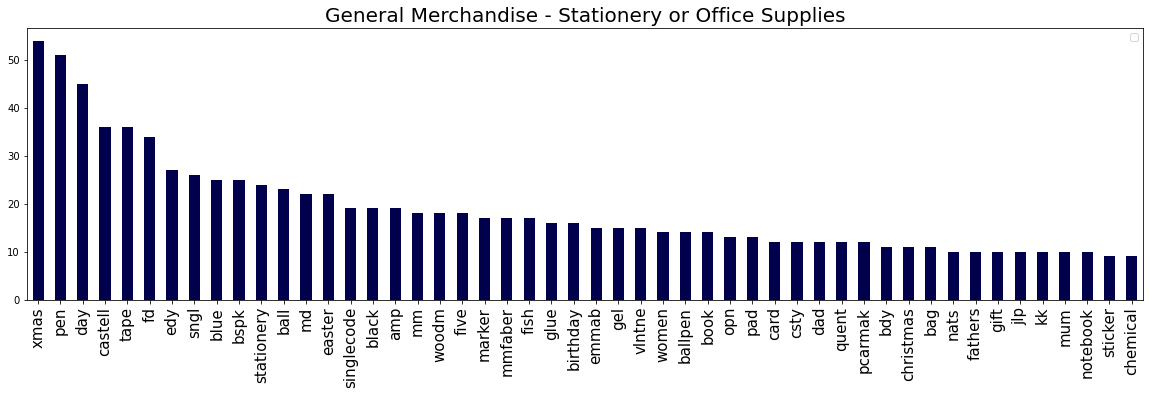

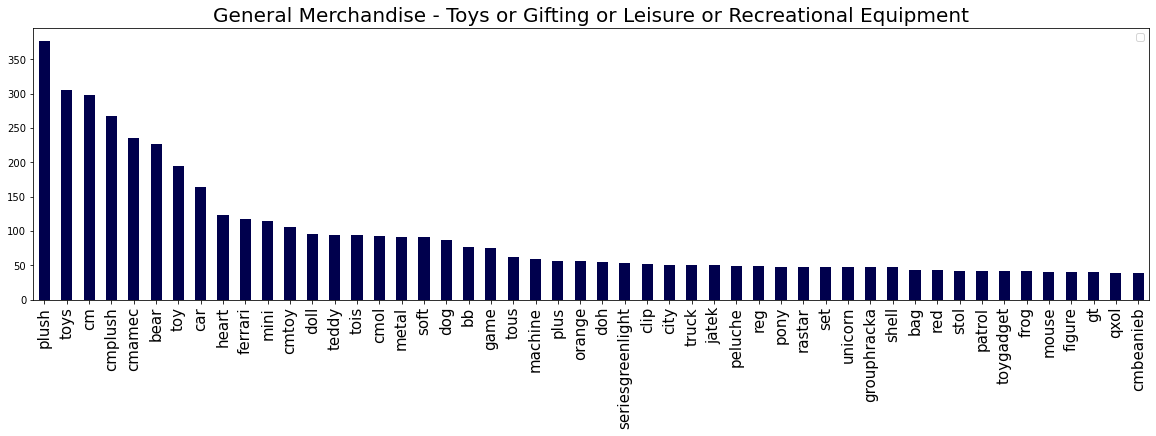

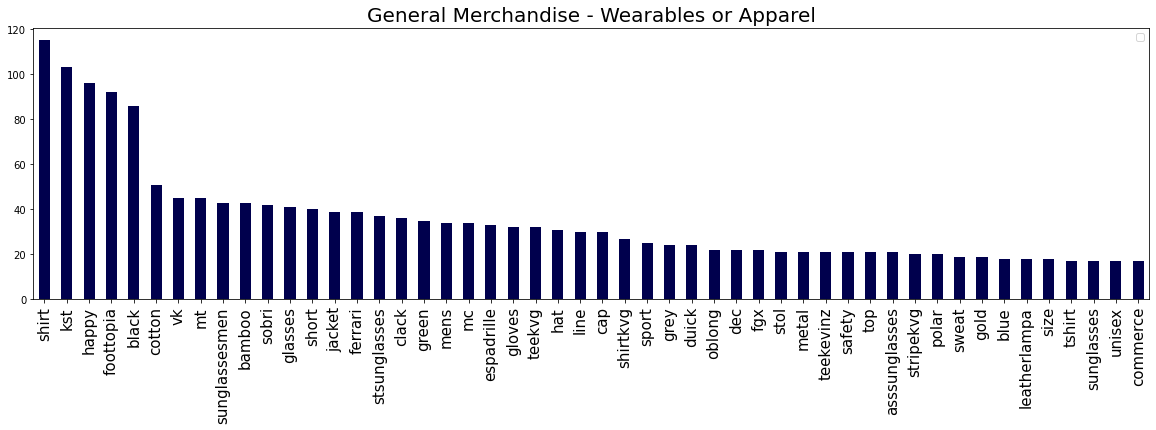

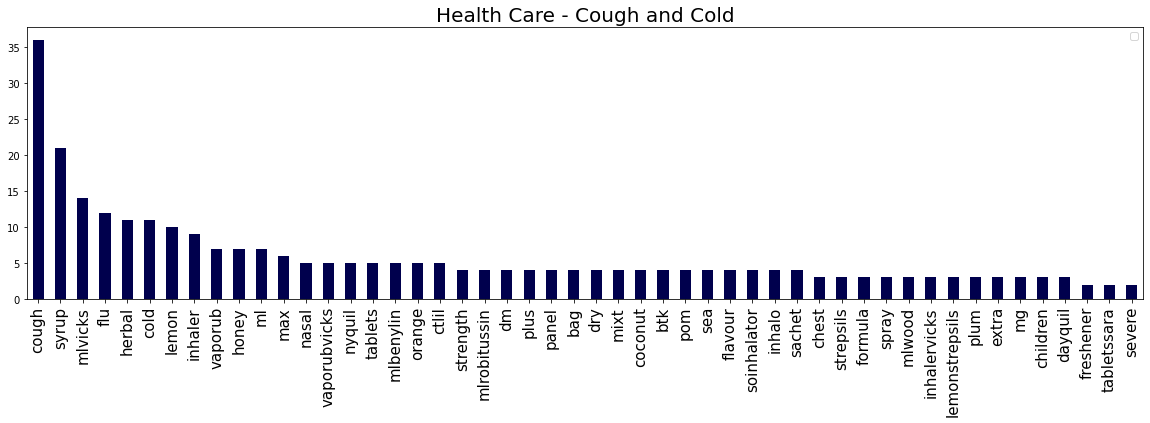

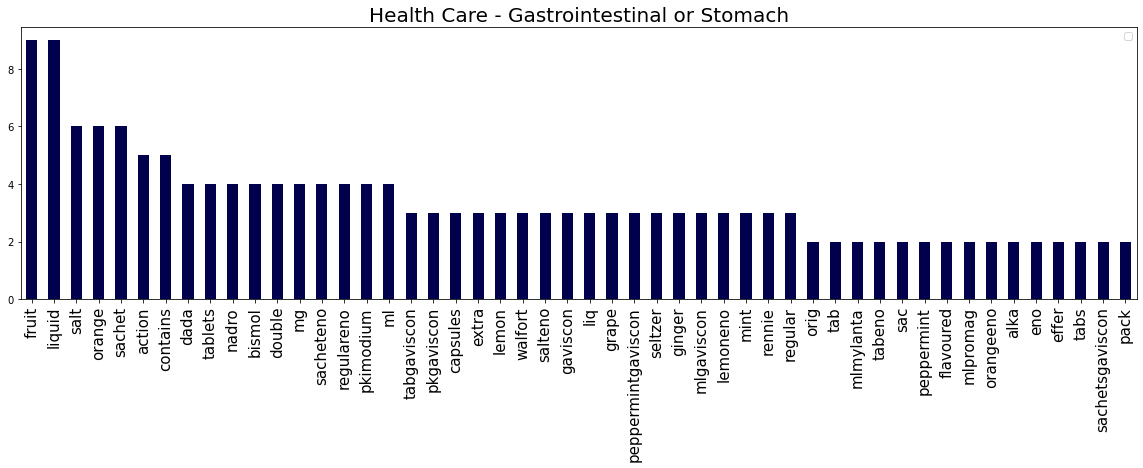

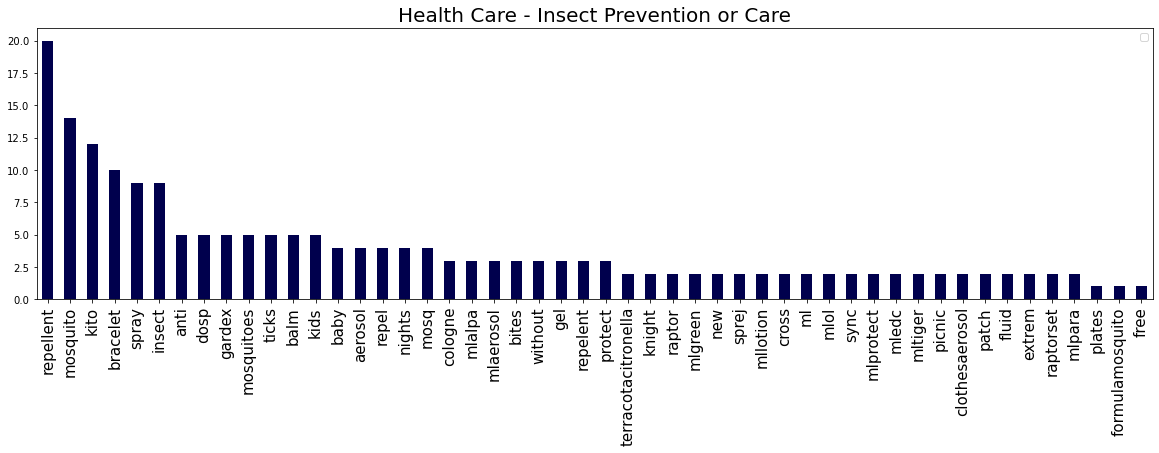

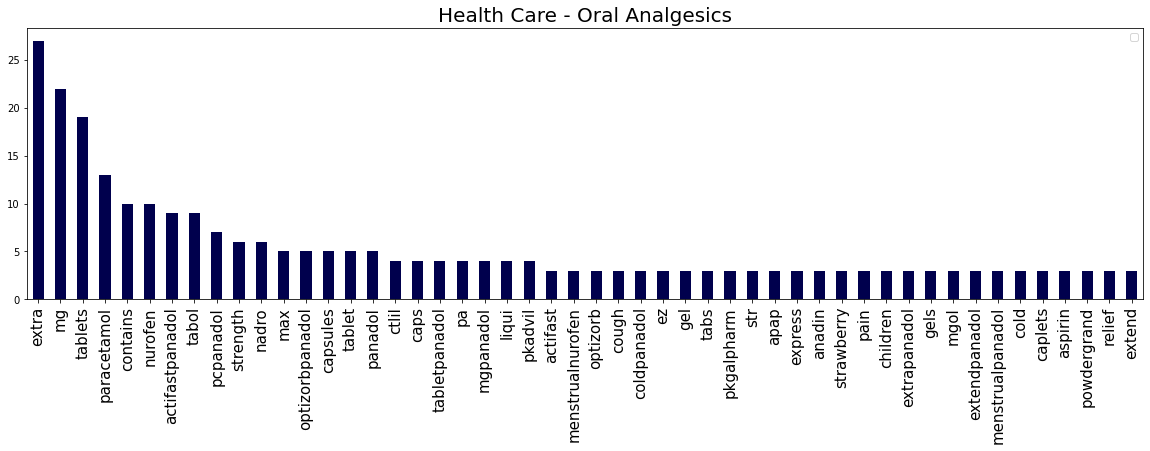

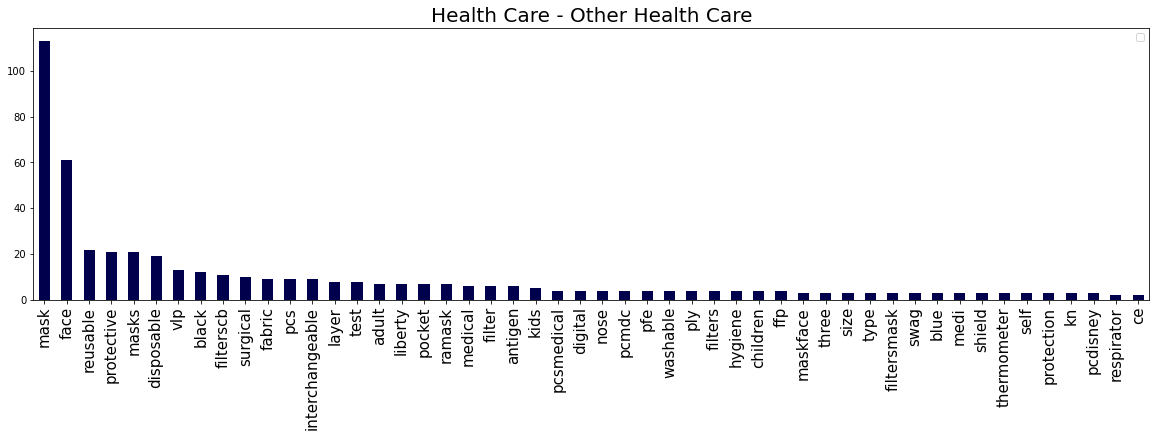

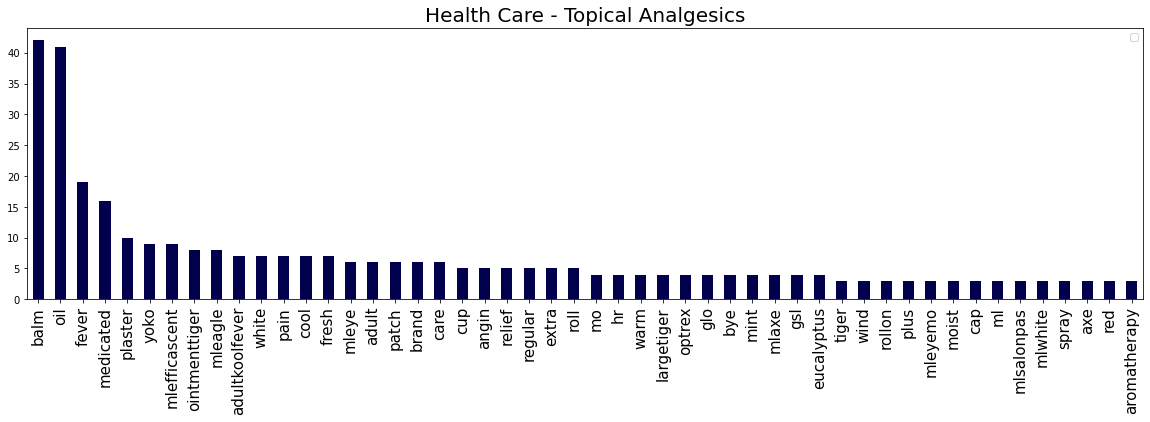

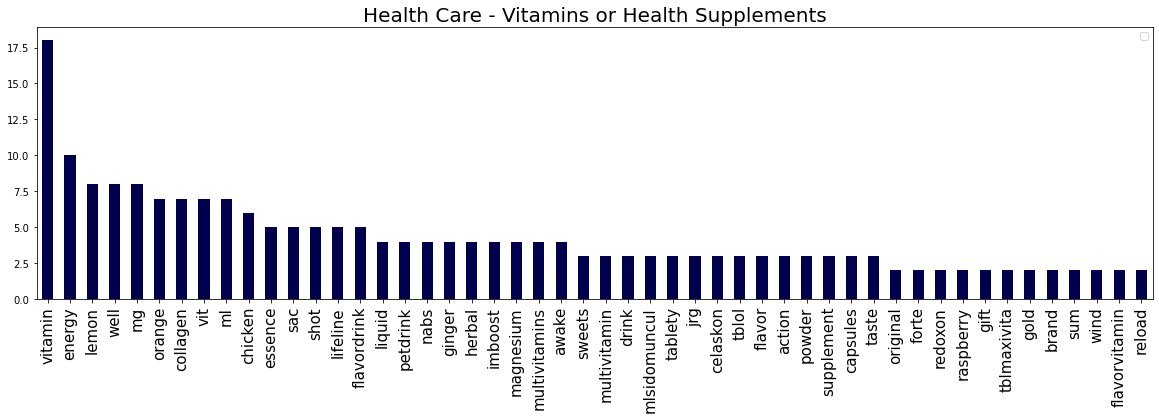

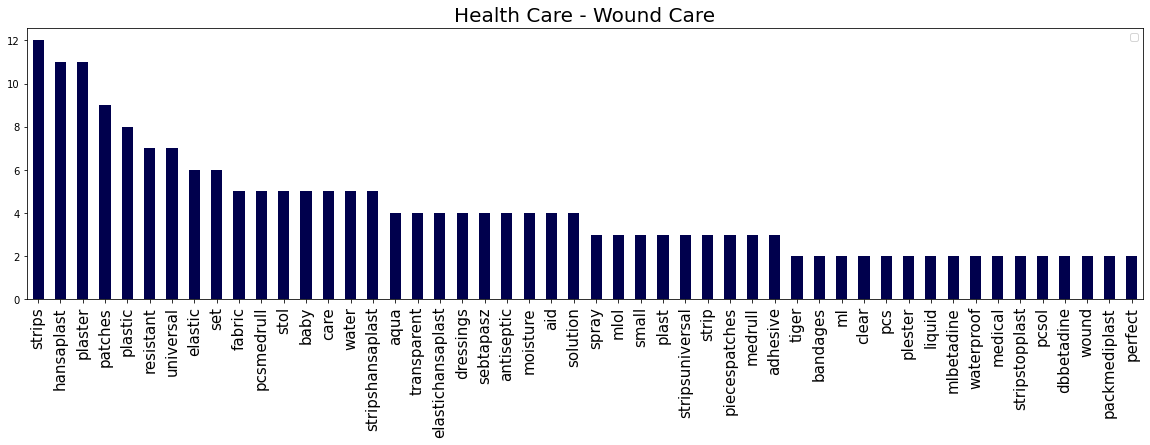

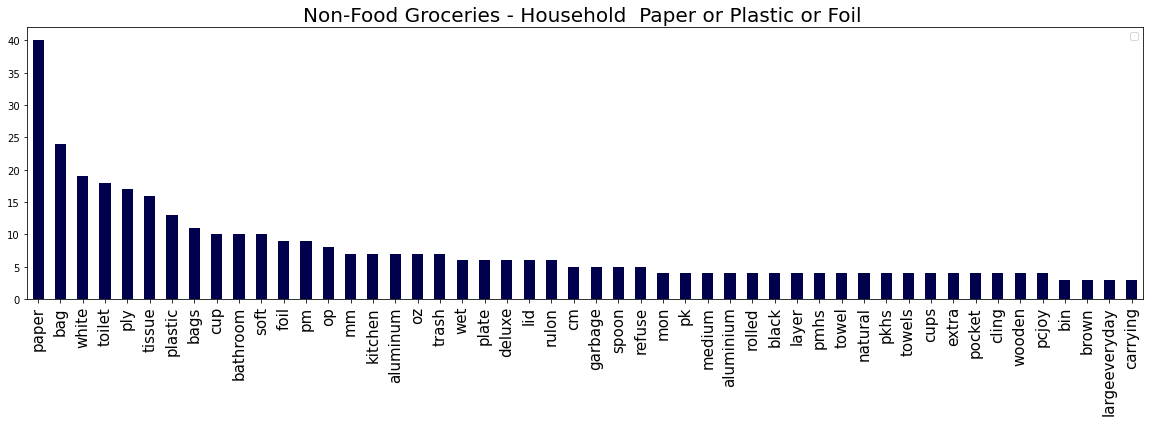

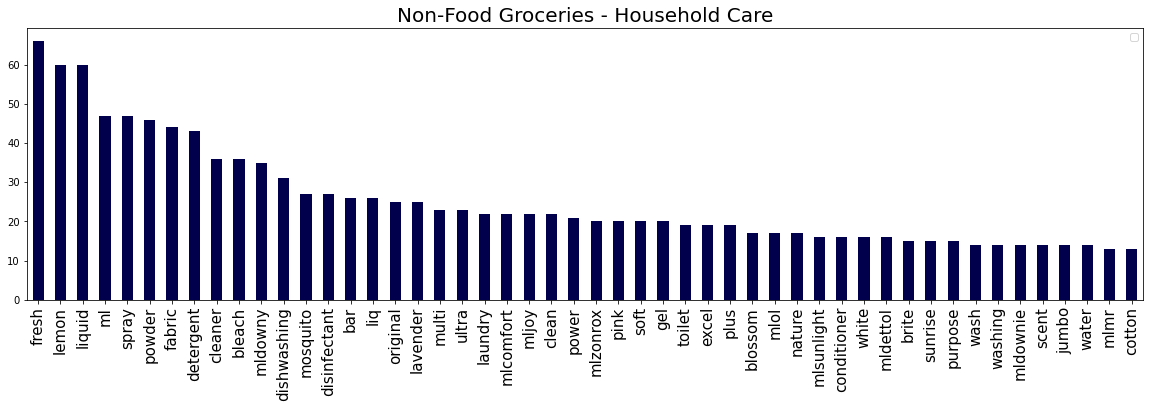

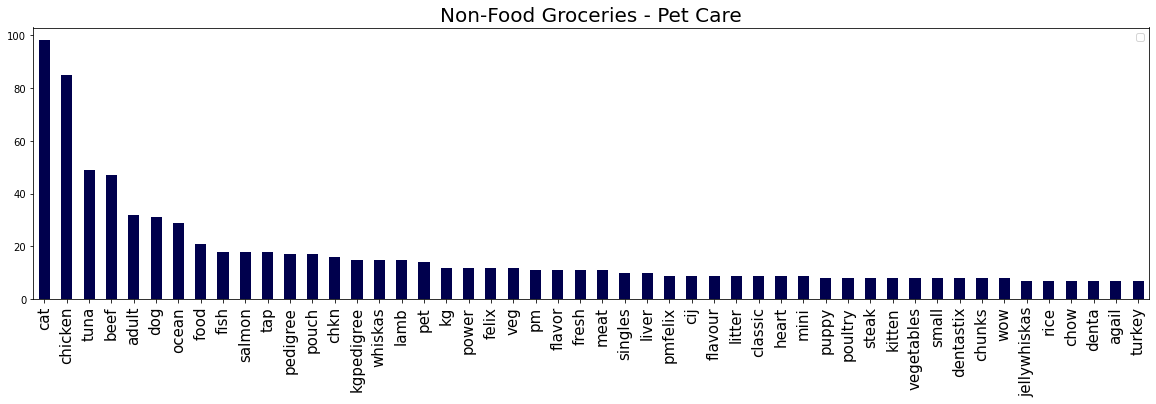

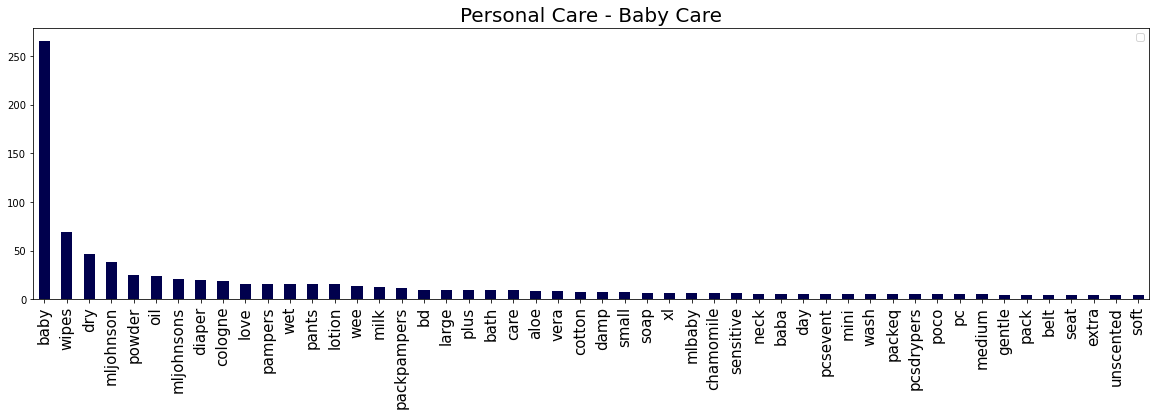

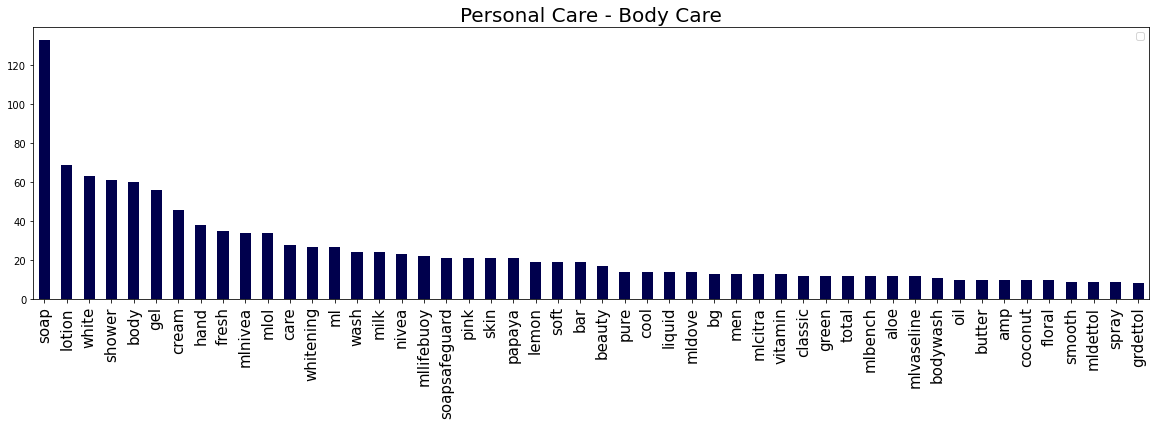

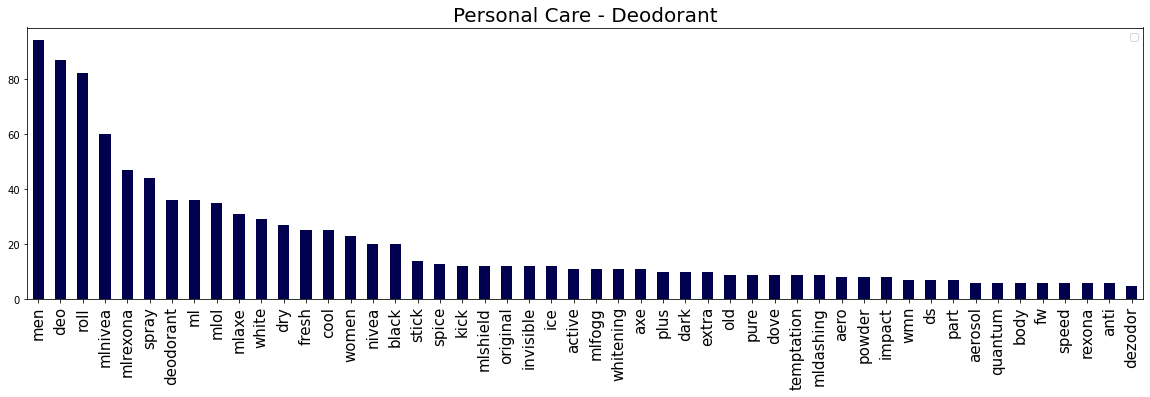

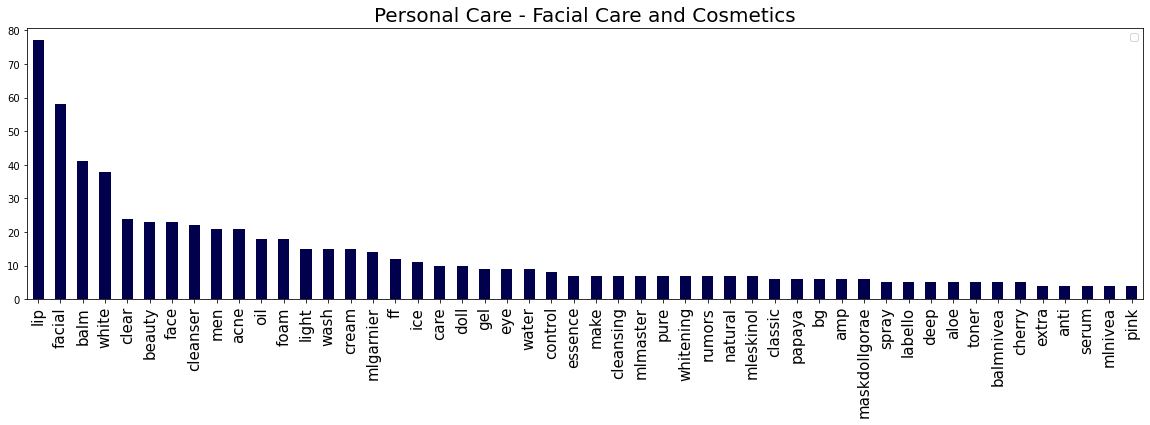

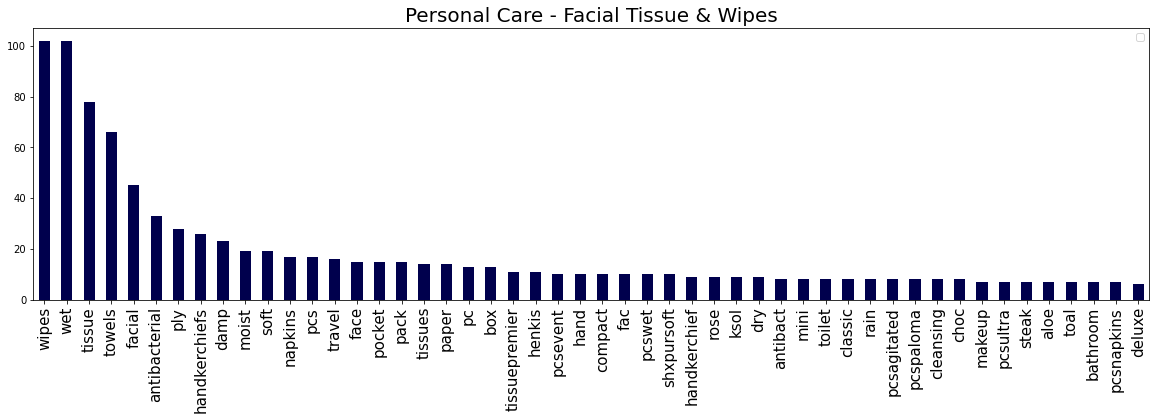

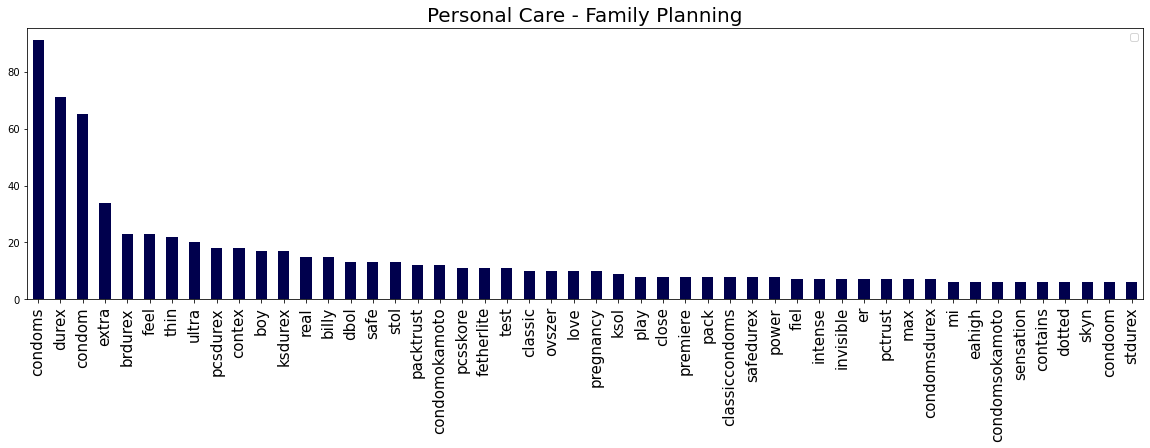

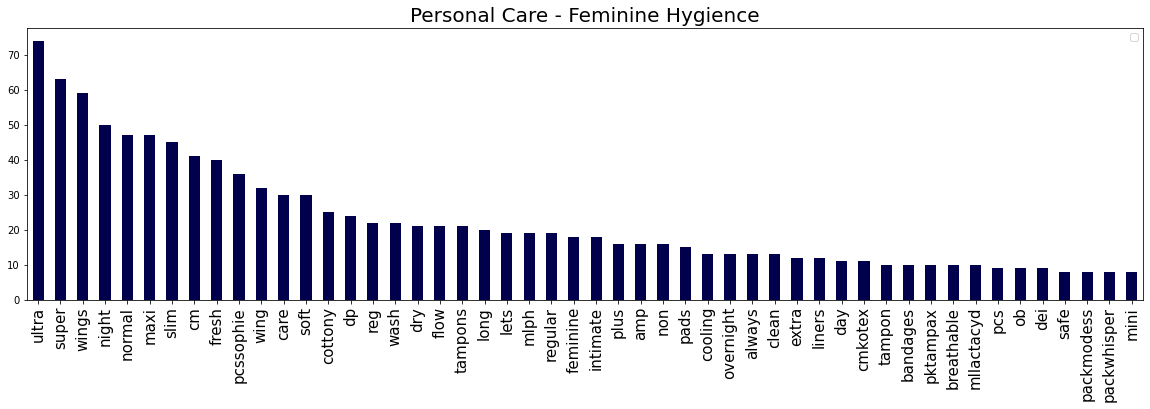

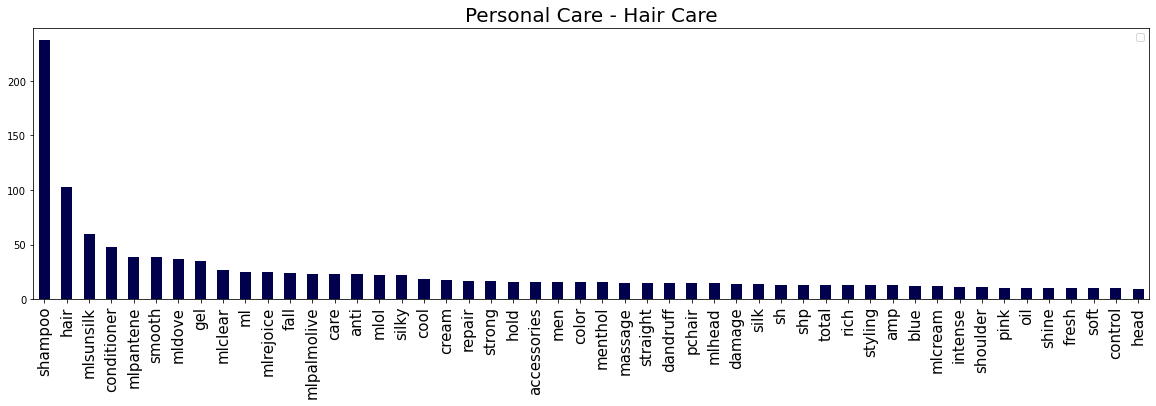

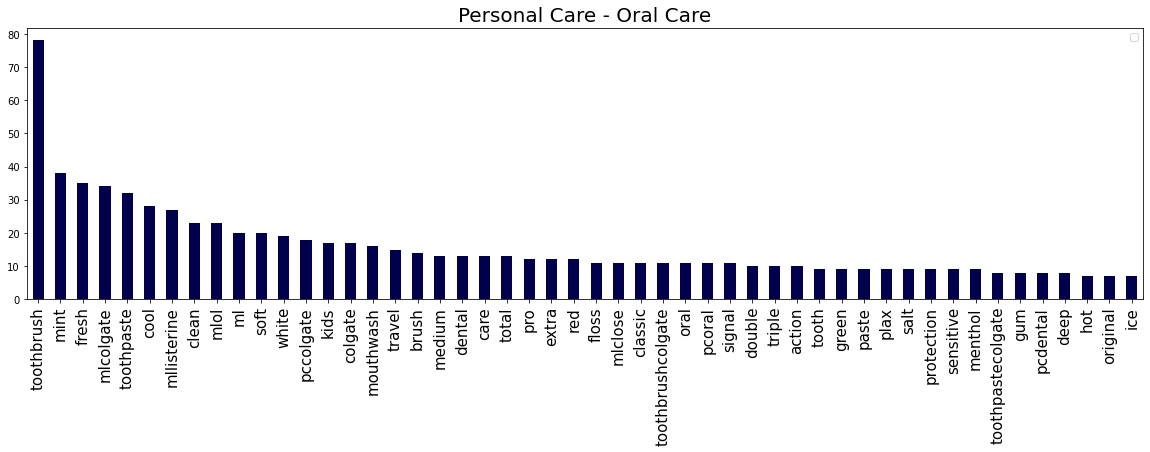

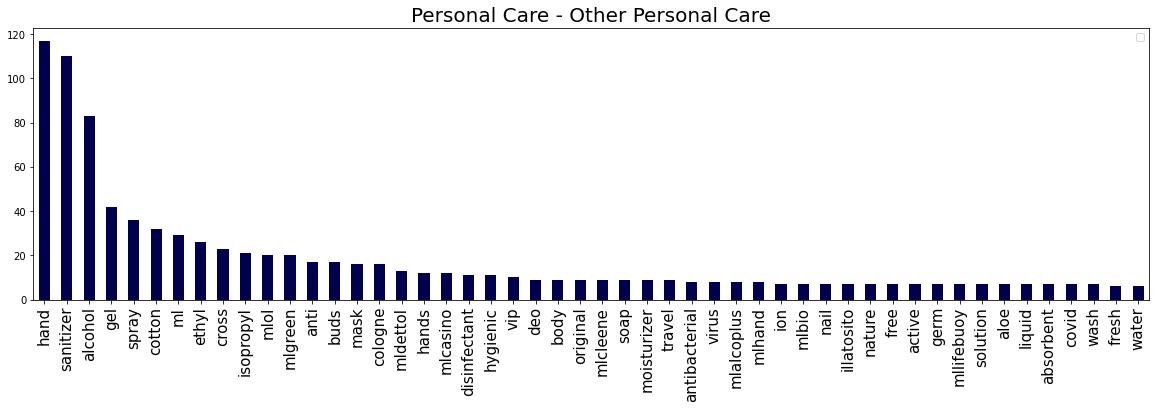

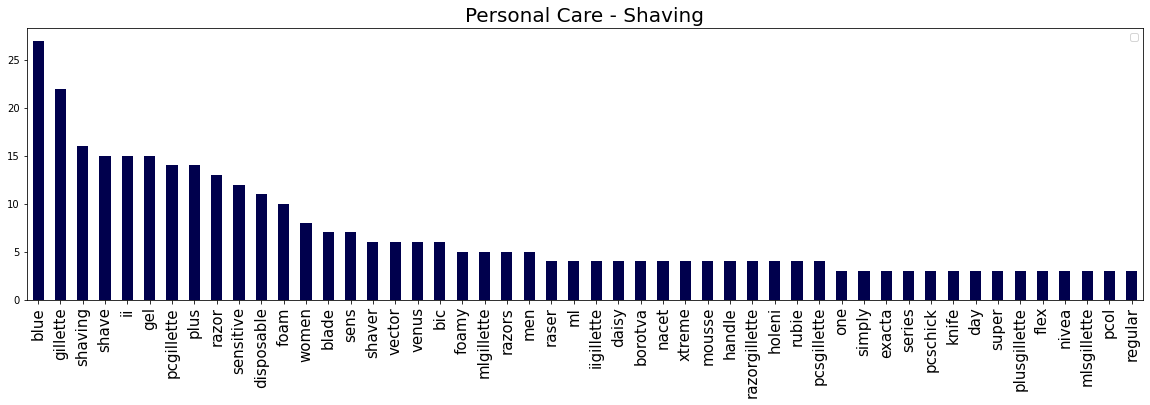

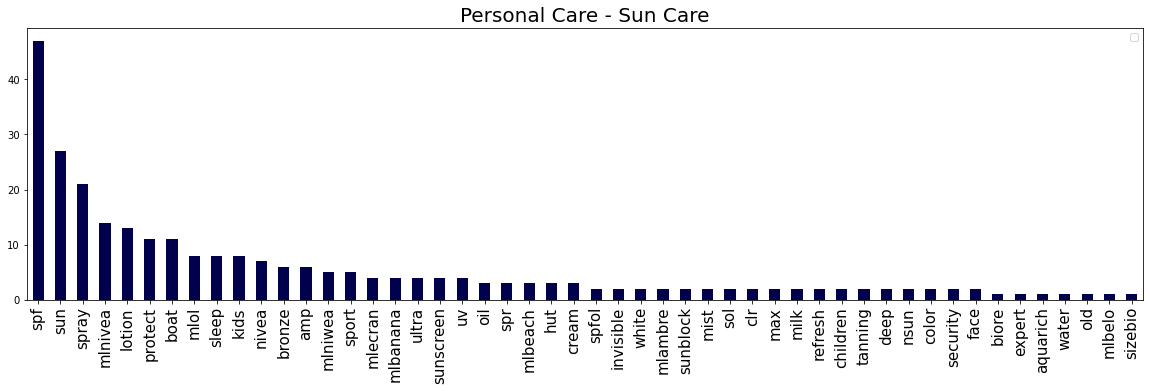

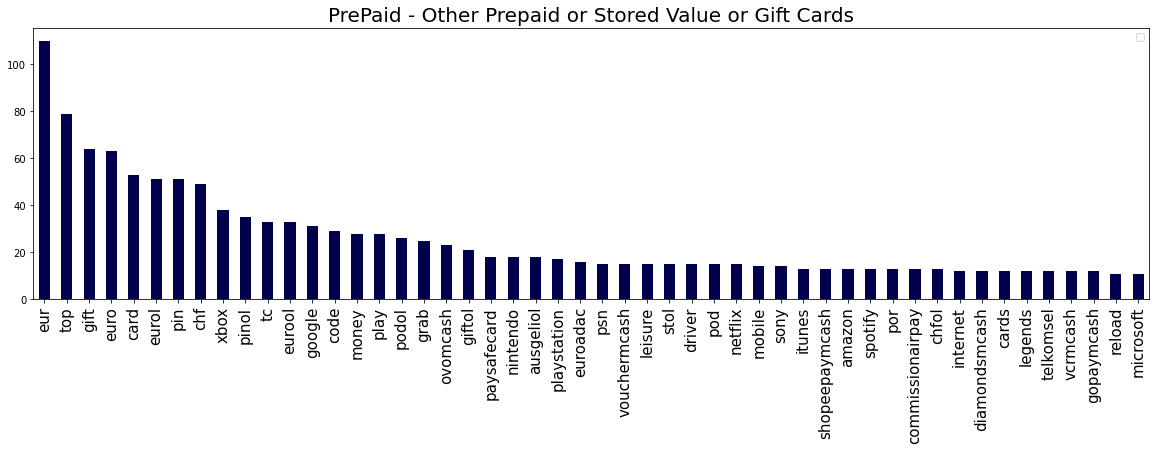

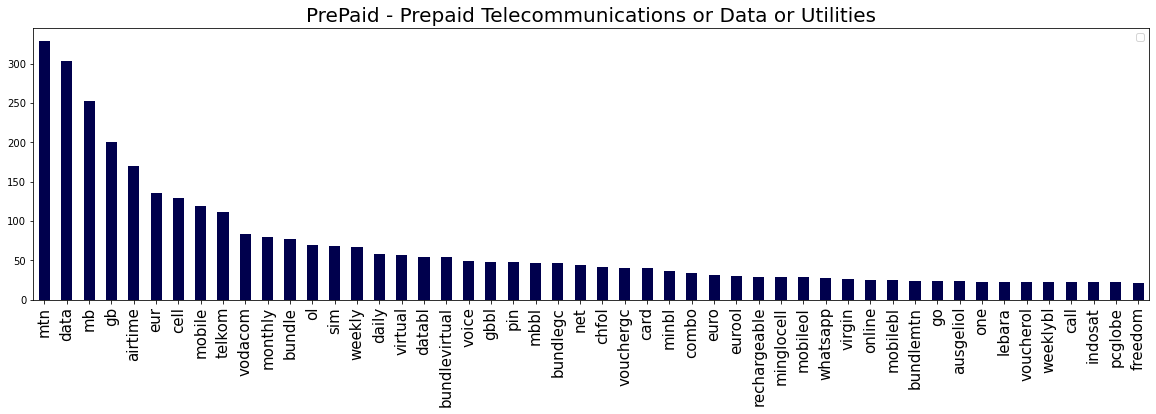

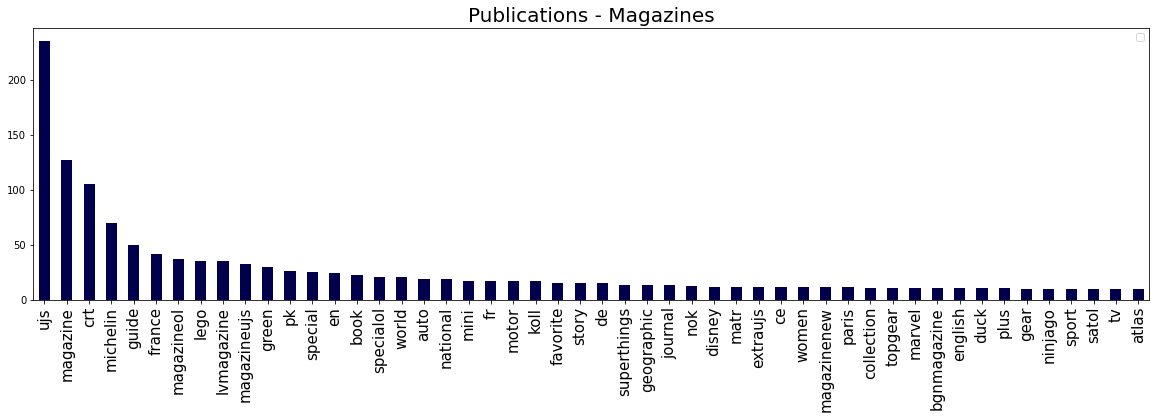

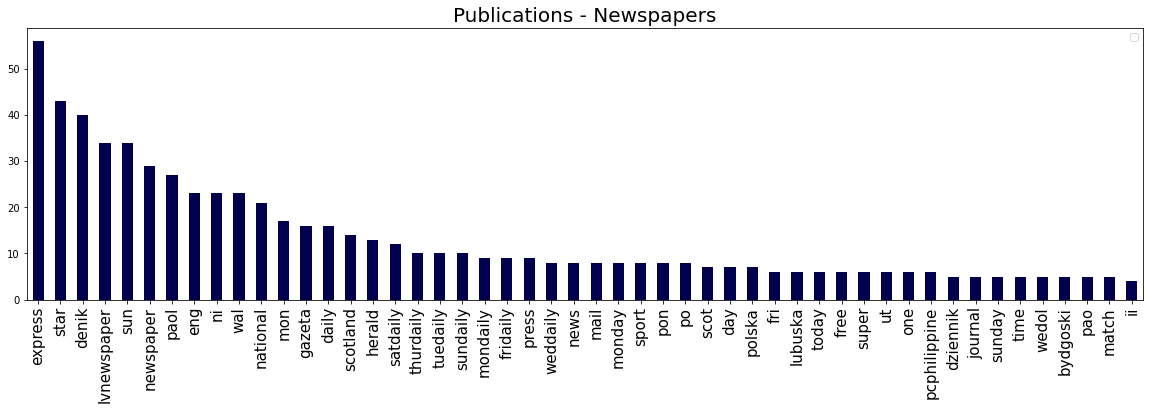

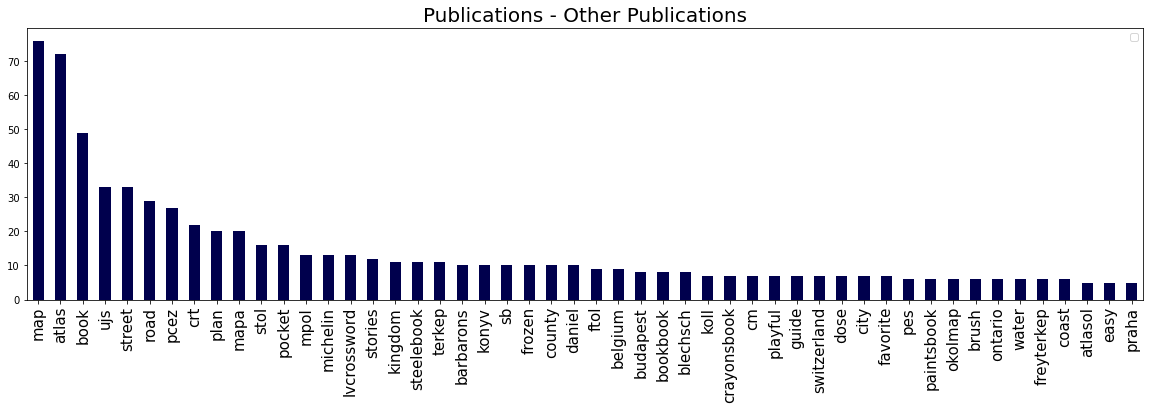

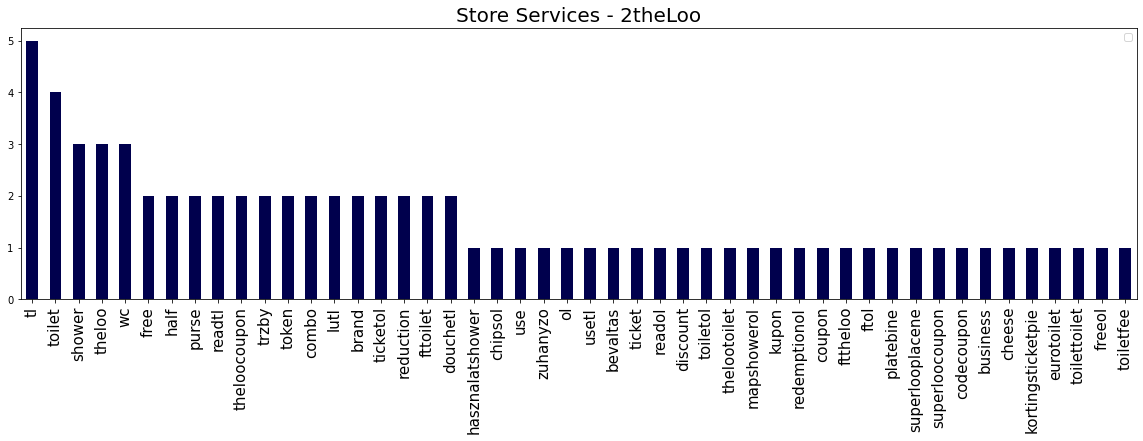

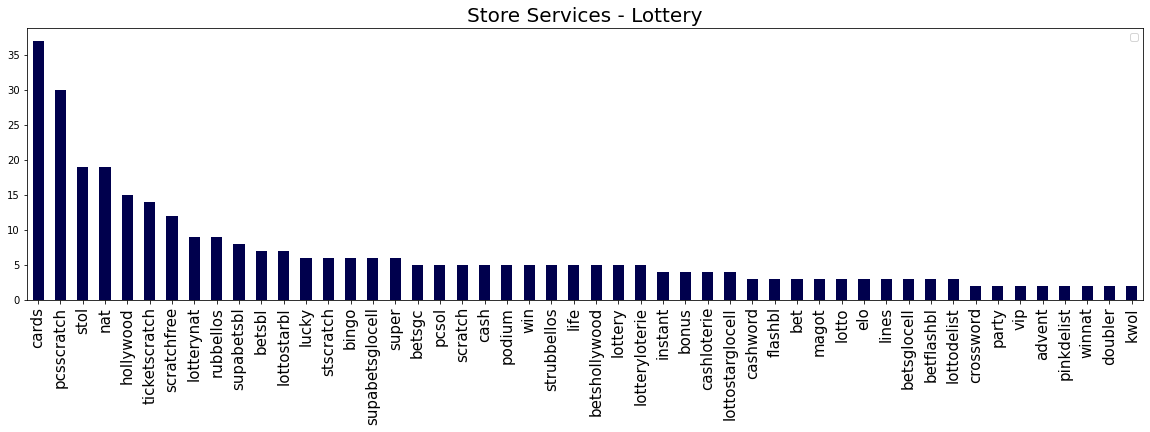

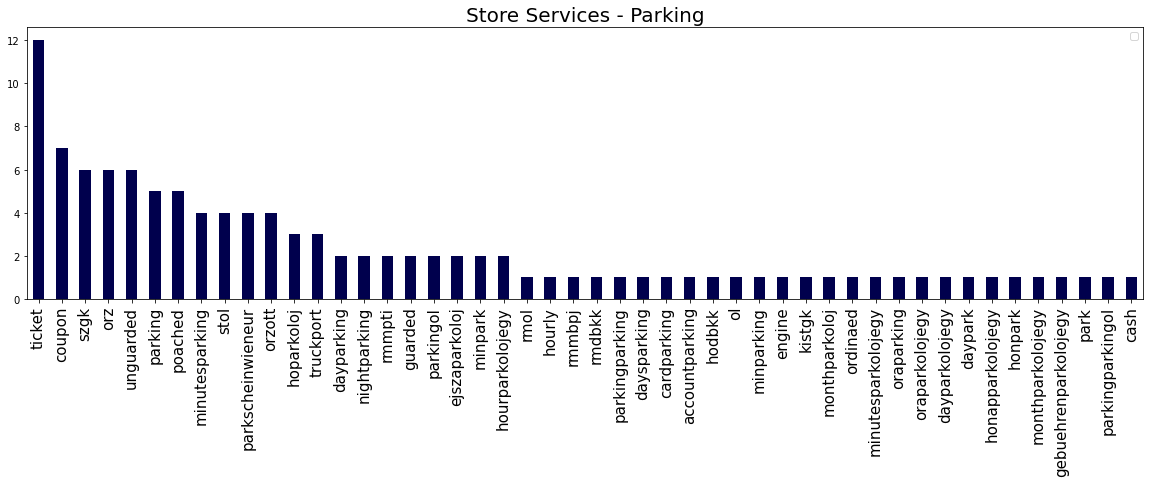

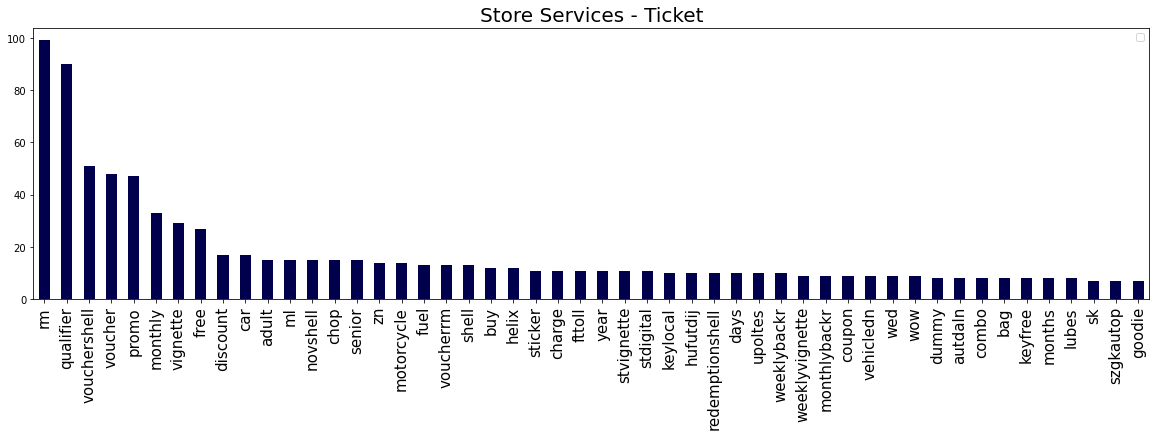

In [27]:
plot_most_common_features(X_cleaner_2,df['Final_Category'])

In [28]:
warnings.filterwarnings('ignore') # Do not print warning messages

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [30]:
def text_p(X):
    return X.apply(lambda x: process_text(x))  

In [31]:
def stemming_func(X):
    return X.apply(lambda x: stemming(x))

In [32]:
count_vect = CountVectorizer(analyzer = "word")
tfidf = TfidfTransformer(norm="l2")

In [33]:
text_process = FunctionTransformer(text_p)
stemming_text = FunctionTransformer(stemming_func)

In [34]:
naive_multi = MultinomialNB()
svc = SVC()
rf = RandomForestClassifier(n_jobs=-1)
lr = LogisticRegression(multi_class='ovr')

In [35]:
pipeline = Pipeline([
    ('process', text_process),
    ('stemmer', stemming_text),
    ('count_vector', count_vect),
    ('tfidf', tfidf),
    ('model', naive_multi)
])
pipeline

Pipeline(steps=[('process',
                 FunctionTransformer(func=<function text_p at 0x0000012A6CFCA310>)),
                ('stemmer',
                 FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>)),
                ('count_vector', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('model', MultinomialNB())])

In [36]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('process',
                 FunctionTransformer(func=<function text_p at 0x0000012A6CFCA310>)),
                ('stemmer',
                 FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>)),
                ('count_vector', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('model', MultinomialNB())])

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
matthews_corrcoef(y_train, pipeline.predict(X_train))

0.7654452162330104

In [39]:
recall_score(y_train, pipeline.predict(X_train), average='macro')

0.5151021379649587

In [40]:
#GridSearch

In [41]:
Cs = 10**np.linspace(-1,2,3)
gammas = 10**np.linspace(-2,1,5)

In [42]:
param_grid = [
    {'model': [svc], 'model__kernel': ['linear'], 'model__C': Cs, 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [svc], 'model__kernel': ['rbf'], 'model__gamma': gammas, 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [naive_multi], 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [lr], 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]},
    {'model': [rf], 'tfidf': [None, tfidf], 'stemmer': [None, stemming_text]}
]

In [43]:
cv = ShuffleSplit(n_splits=5, test_size=0.2)

In [44]:
sklearn.metrics.get_scorer

<function sklearn.metrics._scorer.get_scorer(scoring)>

In [45]:
#%%time
#gs = GridSearchCV(
    #pipeline,
    #param_grid,
    #cv = cv,
    #n_jobs=-1
    #scoring=make_scorer(matthews_corrcoef)
#)
#gs.fit(X_train, y_train)

In [46]:
#gs = gs.fit(X_train, y_train)

In [47]:
from sklearn.model_selection import RandomizedSearchCV

In [48]:
randcv = RandomizedSearchCV(pipeline,param_grid,cv = cv,n_iter=10,scoring=make_scorer(matthews_corrcoef),verbose=10)
randcv.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model=LogisticRegression(multi_class='ovr'), stemmer=FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>), tfidf=None
[CV 1/5; 1/10] END model=LogisticRegression(multi_class='ovr'), stemmer=FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>), tfidf=None;, score=0.822 total time=  22.9s
[CV 2/5; 1/10] START model=LogisticRegression(multi_class='ovr'), stemmer=FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>), tfidf=None
[CV 2/5; 1/10] END model=LogisticRegression(multi_class='ovr'), stemmer=FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>), tfidf=None;, score=0.821 total time=  23.1s
[CV 3/5; 1/10] START model=LogisticRegression(multi_class='ovr'), stemmer=FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>), tfidf=None
[CV 3/5; 1/10] END model=LogisticRegression(multi_class='ovr'), stemmer=FunctionTr

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('process',
                                              FunctionTransformer(func=<function text_p at 0x0000012A6CFCA310>)),
                                             ('stemmer',
                                              FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>)),
                                             ('count_vector',
                                              CountVectorizer()),
                                             ('tfidf', TfidfTransformer()),
                                             ('model'...
                                        {'model': [LogisticRegression(multi_class='ovr')],
                                         'stemmer': [None,
                                                     FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>)],
                                         'tfidf': [None, TfidfTransformer()]},
                                        {'model': [RandomForestClassifier(n_jobs=-1)],
                                         'stemmer': [None,
                                                     FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>)],
                                         'tfidf': [None, TfidfTransformer()]}],
                   scoring=make_scorer(matthews_corrcoef), verbose=10)

In [49]:
#gs_results = pd.DataFrame(gs.cv_results_).sort_values(['rank_test_score'])
#gs_results.head()

In [50]:
randcv_results = pd.DataFrame(randcv.cv_results_).sort_values(['rank_test_score'])
randcv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9      44.370162      0.245463        12.338724        0.267639   
5      39.106531      0.239853        11.808027        0.189386   
0      19.444559      1.353680         2.504551        0.349430   
1      17.916810      1.734483         2.609824        0.640857   
3      44.611041      6.032446        10.490448        1.406353   

          param_tfidf                                      param_stemmer  \
9  TfidfTransformer()  FunctionTransformer(func=<function stemming_fu...   
5                None  FunctionTransformer(func=<function stemming_fu...   
0                None  FunctionTransformer(func=<function stemming_fu...   
1  TfidfTransformer()                                               None   
3  TfidfTransformer()                                               None   

                             param_model param_model__kernel  \
9          SVC(C=100.0, kernel='linear')              linear   
5          SVC(C=100.0, kernel='linear')              linear   
0  LogisticRegression(multi_class='ovr')                 NaN   
1      RandomForestClassifier(n_jobs=-1)                 NaN   
3          SVC(C=100.0, kernel='linear')                 rbf   

  param_model__gamma param_model__C  \
9                NaN          100.0   
5                NaN       3.162278   
0                NaN            NaN   
1                NaN            NaN   
3           0.316228            NaN   

                                              params  split0_test_score  \
9  {'tfidf': TfidfTransformer(), 'stemmer': Funct...           0.853962   
5  {'tfidf': None, 'stemmer': FunctionTransformer...           0.840080   
0  {'tfidf': None, 'stemmer': FunctionTransformer...           0.822053   
1  {'tfidf': TfidfTransformer(), 'stemmer': None,...           0.813945   
3  {'tfidf': TfidfTransformer(), 'stemmer': None,...           0.797778   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
9           0.850730           0.847668           0.858002           0.863894   
5           0.837117           0.837064           0.849610           0.846018   
0           0.820622           0.812411           0.827470           0.825073   
1           0.809024           0.807759           0.817474           0.812199   
3           0.796954           0.789011           0.801307           0.793711   

   mean_test_score  std_test_score  rank_test_score  
9         0.854851        0.005676                1  
5         0.841978        0.005019                2  
0         0.821526        0.005140                3  
1         0.812080        0.003481                4  
3         0.795752        0.004148                5

In [51]:
randcv.best_score_

0.8548511359757409

In [52]:
#gs.best_score_

In [53]:
#best_params = gs.best_estimator_.get_params()

In [54]:
best_params = randcv.best_estimator_.get_params()

In [55]:
pipeline.set_params(**best_params)

Pipeline(steps=[('process',
                 FunctionTransformer(func=<function text_p at 0x0000012A6CFCA310>)),
                ('stemmer',
                 FunctionTransformer(func=<function stemming_func at 0x0000012A6CFCA280>)),
                ('count_vector', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('model', SVC(C=100.0, kernel='linear'))])

In [56]:
matthews_corrcoef(y_test, pipeline.predict(X_test))

0.856727934407928

(array([3., 0., 1., 5., 2., 5., 9., 9., 6., 3.]),
 array([0.58823529, 0.62941176, 0.67058824, 0.71176471, 0.75294118,
        0.79411765, 0.83529412, 0.87647059, 0.91764706, 0.95882353,
        1.        ]),
 <BarContainer object of 10 artists>)

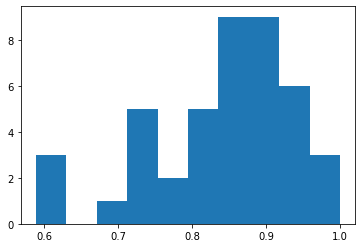

In [57]:
plt.hist(recall_score(y_test, pipeline.predict(X_test), average=None))

(array([0.06976744, 0.06976744, 0.09302326, 0.20930233, 0.25581395,
        0.37209302, 0.58139535, 0.79069767, 0.93023256, 1.        ]),
 array([0.58823529, 0.62941176, 0.67058824, 0.71176471, 0.75294118,
        0.79411765, 0.83529412, 0.87647059, 0.91764706, 0.95882353,
        1.        ]),
 <BarContainer object of 10 artists>)

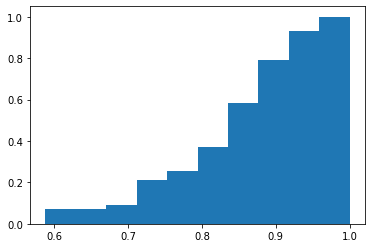

In [58]:
plt.hist(recall_score(y_test, pipeline.predict(X_test), average=None), cumulative=True, density=True)

In [59]:
recall_score(y_test, pipeline.predict(X_test), average='macro')

0.8425957767966697

In [60]:
test_set = pd.read_excel('test_set2_8.xlsx')

In [61]:
final_prediction = pd.DataFrame(X_test.copy())

In [62]:
test_set['Prediction'] = pipeline.predict(test_set['Production Description Test'])

In [63]:
test_set.head(20)

Production Description Test  Prediction
0                       Cable ties 15x3.6cm 100pcs Pg           9
1                          Women's Knee Stocking2Pair          10
2                            Defrost stray salt 25 kg           7
3                Elephant with scarf 21cm (12) Pg 1st           9
4                  OL: Sicherheitsw Orange (50)   1St          35
5                  OL: Sicherheitsw Orange (50)   1St          35
6   OL: SonnenbrilleKstGreenLineMattSchwarzOranVK1...          38
7                      OL: Fertiglesebrille Dpt +2.50           9
8                      OL: Fertiglesebrille Dpt +3.00           9
9                                    Happy Pillow 1st          40
10                         Kw Crates M 12fl/Euro 4.80          40
11                            Sunglasses LP 14.99Euro          10
12                        Emerald Langstielrosen Rot/           9
13                            Sunglasses LP 14.99Euro          10
14                            Sunglasses LP 19.99Euro          10
15                                        Other goods           6
16                                        Other goods           6
17                              Emerald Arangement M/           9
18                              Pot Roses In Ceramic/           5
19             Dried flowers 13.49 / Trendflowers 1st           9

In [64]:
test_set.replace({'Prediction': code_dictionary}, inplace=True)

In [65]:
test_set.head()

Production Description Test  \
0         Cable ties 15x3.6cm 100pcs Pg   
1            Women's Knee Stocking2Pair   
2              Defrost stray salt 25 kg   
3  Elephant with scarf 21cm (12) Pg 1st   
4    OL: Sicherheitsw Orange (50)   1St   

                                          Prediction  
0  General Merchandise - Toys or Gifting or Leisu...  
1         General Merchandise - Wearables or Apparel  
2          General Merchandise - Outdoor or Seasonal  
3  General Merchandise - Toys or Gifting or Leisu...  
4  PrePaid - Prepaid Telecommunications or Data o...

In [66]:
test_set = test_set.join(test_set['Prediction'].str.split('-', expand=True).rename(columns={0:'Predicted IPH Category', 1: 'Predicted IPH Sub Category'}))

In [67]:
test_set.head(20)

Production Description Test  \
0                       Cable ties 15x3.6cm 100pcs Pg   
1                          Women's Knee Stocking2Pair   
2                            Defrost stray salt 25 kg   
3                Elephant with scarf 21cm (12) Pg 1st   
4                  OL: Sicherheitsw Orange (50)   1St   
5                  OL: Sicherheitsw Orange (50)   1St   
6   OL: SonnenbrilleKstGreenLineMattSchwarzOranVK1...   
7                      OL: Fertiglesebrille Dpt +2.50   
8                      OL: Fertiglesebrille Dpt +3.00   
9                                    Happy Pillow 1st   
10                         Kw Crates M 12fl/Euro 4.80   
11                            Sunglasses LP 14.99Euro   
12                        Emerald Langstielrosen Rot/   
13                            Sunglasses LP 14.99Euro   
14                            Sunglasses LP 19.99Euro   
15                                        Other goods   
16                                        Other goods   
17                              Emerald Arangement M/   
18                              Pot Roses In Ceramic/   
19             Dried flowers 13.49 / Trendflowers 1st   

                                           Prediction Predicted IPH Category  \
0   General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
1          General Merchandise - Wearables or Apparel   General Merchandise    
2           General Merchandise - Outdoor or Seasonal   General Merchandise    
3   General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
4   PrePaid - Prepaid Telecommunications or Data o...               PrePaid    
5   PrePaid - Prepaid Telecommunications or Data o...               PrePaid    
6                   Publications - Other Publications          Publications    
7   General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
8   General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
9                            Store Services - Lottery        Store Services    
10                           Store Services - Lottery        Store Services    
11         General Merchandise - Wearables or Apparel   General Merchandise    
12  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
13         General Merchandise - Wearables or Apparel   General Merchandise    
14         General Merchandise - Wearables or Apparel   General Merchandise    
15    General Merchandise - Other General Merchandise   General Merchandise    
16    General Merchandise - Other General Merchandise   General Merchandise    
17  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    
18                       General Merchandise - Floral   General Merchandise    
19  General Merchandise - Toys or Gifting or Leisu...   General Merchandise    

                           Predicted IPH Sub Category     2  
0    Toys or Gifting or Leisure or Recreational Eq...  None  
1                                Wearables or Apparel  None  
2                                 Outdoor or Seasonal  None  
3    Toys or Gifting or Leisure or Recreational Eq...  None  
4     Prepaid Telecommunications or Data or Utilities  None  
5     Prepaid Telecommunications or Data or Utilities  None  
6                                  Other Publications  None  
7    Toys or Gifting or Leisure or Recreational Eq...  None  
8    Toys or Gifting or Leisure or Recreational Eq...  None  
9                                             Lottery  None  
10                                            Lottery  None  
11                               Wearables or Apparel  None  
12   Toys or Gifting or Leisure or Recreational Eq...  None  
13                               Wearables or Apparel  None  
14                               Wearables or Apparel  None  
15                          Other General Merchandise  None  
16                          Other General Merchandise  None  
17   Toys or Gifting or Leisure

In [68]:
test_set.to_csv('iphpredictions2_8.csv')